In [11]:
# scores is a function which takes names of two strategies and return related scores between those two strategies 
def scores(m1,m2):
    import numpy as np
    from itertools import combinations 
    from copy import deepcopy
    from sklearn.preprocessing import normalize



    def Reward(S1,S2):
        ep = 0
        S2 = deepcopy(S2[0] + S2[2] + S2[1] + S2[3])
        P0 = np.zeros((4,4))
        for i in range(8):
            for j in range(4):
                if i == 0:
                    P0[i,j] = abs(int(S1[j])-ep) * abs(int(S2[j])-ep)
                elif i == 1:
                    P0[i,j] = abs(int(S1[j])-ep) * (1-abs(int(S2[j])-ep))
                elif i == 2:
                    P0[i,j] = (1-abs(int(S1[j])-ep)) * abs(int(S2[j]))
                elif i == 3:
                    P0[i,j] = (1-abs(int(S1[j])-ep)) * (1-abs(int(S2[j])-ep))

        P = np.concatenate((P0,P0),axis = 1)
        P = np.concatenate((P,P),axis = 0)


        cc = np.array([1,1,1,1,0,0,0,0])
        cc = cc.reshape(1,8)
        ot = np.array([0,0,0,0,1,1,1,1])
        ot = ot.reshape(1,8)

        Q = np.transpose(np.concatenate((cc,ot,ot,ot,cc,ot,ot,ot)))

        P_f = P * Q


        return P_f


    # In[22]:


    def Strategy_Matrix(strategy_list = ['0000','0001','0010','0011','0100','0101',
                     '0110','0111','1000','1001','1010','1100',
                     '1011','1101','1110','1111'], b1 = 2, b2 = 1.2):

        l = len(strategy_list)

        pair_list_up = list(combinations(strategy_list, 2))

        pair_list_low = []
        for p in pair_list_up:
            pair_list_low.append((p[1],p[0]))


        bonus = np.array([b1-1,-1,b1,0,b2-1,-1,b2,0]).reshape(8,1)



        U = []
        for up in pair_list_up:
            p = Reward(up[0],up[1])

            w, v = np.linalg.eig(p)

            v = abs((v[:,np.where(w == 1)[0]])/(np.linalg.norm(v[:,np.where(w == 1)[0]],axis = 0,ord=1)))
            re = bonus * v
            r = np.mean(re[re!=0])
            U.append(r)

    ###############################

        L = []
        for low in pair_list_low:
            p = Reward(low[0],low[1])

            w, v = np.linalg.eig(p)

            v = abs((v[:,np.where(w == 1)[0]])/(np.linalg.norm(v[:,np.where(w == 1)[0]],axis = 0,ord=1)))
            re = bonus * v
            r = np.mean(re[re!=0])
            L.append(r)  

    ###############################       

        D = []
        for d in strategy_list:
            p = Reward(d,d)

            w, v = np.linalg.eig(p)

            v = abs((v[:,np.where(w == 1)[0]])/(np.linalg.norm(v[:,np.where(w == 1)[0]],axis = 0,ord=1)))
            re = bonus * v
            r = np.mean(re[re!=0])
            D.append(r)

    ###############################

        S = np.zeros((l,l))

        S[np.triu_indices(l,1)] = L
        S = np.transpose(S)
        S[np.triu_indices(l,1)] = U
        np.fill_diagonal(S,D)



        return S



    # In[21]:


    ### strategy = cc,cd,dc,dd
    strategy_list = ['0000','0001','0010','0011','0100','0101',
                     '0110','0111','1000','1001','1010','1100',
                     '1011','1101','1110','1111']
    score_matrix=np.nan_to_num(Strategy_Matrix())#the full matrix of scores between all strategies
    return score_matrix[m1,m1],score_matrix[m2,m2],score_matrix[m1,m2],score_matrix[m2,m1]

In [12]:
#takes the position of a block and returns one of its neighboures depends on k
def neighbour(i,j,k): #K:right neighbour or left ones
    if k==0:
        hi=(i-1)%N
        hj=(j)%N
    if k==1:
        hi=i
        hj=(j-1)%N
    return hi,hj

In [13]:
# compute the chance of birth based on the score
def probscore(s):
    ro=np.power(np.e,(betha*s))
    return ro

In [14]:
# locates the prisoner strategie in the prison corner
def prison(prisoner):
    global l
    l=np.ones((N,N))
    repeat=0
    for i in range(N):
        for j in range(N):
            if repeat< prisoner:
#                 print("hop")
                l[i,j]=-1
                repeat+=1
    

In [15]:
#finds the total score for each strategy
def sum_s(S):
    ind1,ind2=np.where(l==-1)
    sum_s2=0
    for i1,i2 in zip(ind1,ind2):
        sum_s2+=S[i1][i2]
    sum_total=np.sum(S)
    sum_s1=sum_total-sum_s2
    return sum_s1,sum_s2

In [16]:
########initial conditions

import numpy as np
import matplotlib.pyplot as plt
runtimes=100#number of games
betha=0.1#learning
N=20 # size of lattice

##### n2 is number of invaders 
n2=1
###### n1 is the number of population
n1=N**2-n2

l=np.ones((N,N)) #the lattice of environment

In [22]:
S=np.zeros((N,N))

In [53]:
#gets the strategies and play a round with them, then compares the blocks and score each block in the score matrix
def main(s1,s2):
    global S
    S=np.zeros((N,N))#the score matrix of all the blocks
    s11,s22,s12,s21=scores(s1,s2)
    for i in range(N):
        for j in range(N):
            for k in range(2):
                x,y=neighbour(i,j,k)
                if l[i,j]==1 and l[x,y]==1:
                    S[i,j]+=s11
                    S[x,y]+=s11
                    
                    print(i,j,"/n",x,y)
                    print(l[i,j],l[x,y])
                    print(S[i,j],S[x,y])
                if l[i,j]==-1 and l[x,y]==-1:
                    S[i,j]+=s22
                    S[x,y]+=s22
                    print(i,j,"/n",x,y)
                    print(l[i,j],l[x,y])
                    print(S[i,j],S[x,y])
                if l[i,j]==-1 and l[x,y]==1:
                    S[i,j]+=s21
                    S[x,y]+=s12
                    print(i,j,"/n",x,y)
                    print(l[i,j],l[x,y])
                    print(S[i,j],S[x,y])
                if l[i,j]==1 and l[x,y]==-1:
                    S[i,j]+=s12
                    S[x,y]+=s21
                    print(i,j,"/n",x,y)
                    print(l[i,j],l[x,y])
                    print(S[i,j],S[x,y])

    

    ro=np.power(np.e,np.array(betha)*S)
    ro1,ro2=sum_s(ro)
    n1=(ro1/(ro1+ro2))*N**2
    print("n1",n1)
    print("n2",N**2-n1)
    n1=int(n1)
    
#     print(N**2-n1)
    prison(N**2-n1)
#     print(l)
    return n1
        
        

u,o 7 8
0 0 /n 9 0
1.0 1.0
1.0 1.0
0 0 /n 0 9
1.0 1.0
2.0 1.0
0 1 /n 9 1
1.0 1.0
1.0 1.0
0 1 /n 0 0
1.0 1.0
2.0 3.0
0 2 /n 9 2
1.0 1.0
1.0 1.0
0 2 /n 0 1
1.0 1.0
2.0 3.0
0 3 /n 9 3
1.0 1.0
1.0 1.0
0 3 /n 0 2
1.0 1.0
2.0 3.0
0 4 /n 9 4
1.0 1.0
1.0 1.0
0 4 /n 0 3
1.0 1.0
2.0 3.0
0 5 /n 9 5
1.0 1.0
1.0 1.0
0 5 /n 0 4
1.0 1.0
2.0 3.0
0 6 /n 9 6
1.0 1.0
1.0 1.0
0 6 /n 0 5
1.0 1.0
2.0 3.0
0 7 /n 9 7
1.0 1.0
1.0 1.0
0 7 /n 0 6
1.0 1.0
2.0 3.0
0 8 /n 9 8
1.0 1.0
1.0 1.0
0 8 /n 0 7
1.0 1.0
2.0 3.0
0 9 /n 9 9
1.0 1.0
2.0 1.0
0 9 /n 0 8
1.0 1.0
3.0 3.0
1 0 /n 0 0
1.0 1.0
1.0 4.0
1 0 /n 1 9
1.0 1.0
2.0 1.0
1 1 /n 0 1
1.0 1.0
1.0 4.0
1 1 /n 1 0
1.0 1.0
2.0 3.0
1 2 /n 0 2
1.0 1.0
1.0 4.0
1 2 /n 1 1
1.0 1.0
2.0 3.0
1 3 /n 0 3
1.0 1.0
1.0 4.0
1 3 /n 1 2
1.0 1.0
2.0 3.0
1 4 /n 0 4
1.0 1.0
1.0 4.0
1 4 /n 1 3
1.0 1.0
2.0 3.0
1 5 /n 0 5
1.0 1.0
1.0 4.0
1 5 /n 1 4
1.0 1.0
2.0 3.0
1 6 /n 0 6
1.0 1.0
1.0 4.0
1 6 /n 1 5
1.0 1.0
2.0 3.0
1 7 /n 0 7
1.0 1.0
1.0 4.0
1 7 /n 1 6
1.0 1.0
2.0 3.0
1 8 /n 0 8
1.0 1.0
1

1.0 1.0
2.0 3.0
4 4 /n 3 4
1.0 1.0
1.0 4.0
4 4 /n 4 3
1.0 1.0
2.0 3.0
4 5 /n 3 5
1.0 1.0
1.0 4.0
4 5 /n 4 4
1.0 1.0
2.0 3.0
4 6 /n 3 6
1.0 1.0
1.0 4.0
4 6 /n 4 5
1.0 1.0
2.0 3.0
4 7 /n 3 7
1.0 1.0
1.0 4.0
4 7 /n 4 6
1.0 1.0
2.0 3.0
4 8 /n 3 8
1.0 1.0
1.0 4.0
4 8 /n 4 7
1.0 1.0
2.0 3.0
4 9 /n 3 9
1.0 1.0
2.0 4.0
4 9 /n 4 8
1.0 1.0
3.0 3.0
5 0 /n 4 0
1.0 1.0
1.0 4.0
5 0 /n 5 9
1.0 1.0
2.0 1.0
5 1 /n 4 1
1.0 1.0
1.0 4.0
5 1 /n 5 0
1.0 1.0
2.0 3.0
5 2 /n 4 2
1.0 1.0
1.0 4.0
5 2 /n 5 1
1.0 1.0
2.0 3.0
5 3 /n 4 3
1.0 1.0
1.0 4.0
5 3 /n 5 2
1.0 1.0
2.0 3.0
5 4 /n 4 4
1.0 1.0
1.0 4.0
5 4 /n 5 3
1.0 1.0
2.0 3.0
5 5 /n 4 5
1.0 1.0
1.0 4.0
5 5 /n 5 4
1.0 1.0
2.0 3.0
5 6 /n 4 6
1.0 1.0
1.0 4.0
5 6 /n 5 5
1.0 1.0
2.0 3.0
5 7 /n 4 7
1.0 1.0
1.0 4.0
5 7 /n 5 6
1.0 1.0
2.0 3.0
5 8 /n 4 8
1.0 1.0
1.0 4.0
5 8 /n 5 7
1.0 1.0
2.0 3.0
5 9 /n 4 9
1.0 1.0
2.0 4.0
5 9 /n 5 8
1.0 1.0
3.0 3.0
6 0 /n 5 0
1.0 1.0
1.0 4.0
6 0 /n 6 9
1.0 1.0
2.0 1.0
6 1 /n 5 1
1.0 1.0
1.0 4.0
6 1 /n 6 0
1.0 1.0
2.0 3.0
6 2 /n 5 2
1

0 0 /n 9 0
-1.0 1.0
1.2 -1.0
0 0 /n 0 9
-1.0 1.0
2.4 -1.0
0 1 /n 9 1
-1.0 1.0
1.2 -1.0
0 1 /n 0 0
-1.0 -1.0
1.2 2.4
0 2 /n 9 2
1.0 1.0
1.0 1.0
0 2 /n 0 1
1.0 -1.0
0.0 2.4
0 3 /n 9 3
1.0 1.0
1.0 1.0
0 3 /n 0 2
1.0 1.0
2.0 1.0
0 4 /n 9 4
1.0 1.0
1.0 1.0
0 4 /n 0 3
1.0 1.0
2.0 3.0
0 5 /n 9 5
1.0 1.0
1.0 1.0
0 5 /n 0 4
1.0 1.0
2.0 3.0
0 6 /n 9 6
1.0 1.0
1.0 1.0
0 6 /n 0 5
1.0 1.0
2.0 3.0
0 7 /n 9 7
1.0 1.0
1.0 1.0
0 7 /n 0 6
1.0 1.0
2.0 3.0
0 8 /n 9 8
1.0 1.0
1.0 1.0
0 8 /n 0 7
1.0 1.0
2.0 3.0
0 9 /n 9 9
1.0 1.0
0.0 1.0
0 9 /n 0 8
1.0 1.0
1.0 3.0
1 0 /n 0 0
1.0 -1.0
-1.0 3.5999999999999996
1 0 /n 1 9
1.0 1.0
0.0 1.0
1 1 /n 0 1
1.0 -1.0
-1.0 3.5999999999999996
1 1 /n 1 0
1.0 1.0
0.0 1.0
1 2 /n 0 2
1.0 1.0
1.0 2.0
1 2 /n 1 1
1.0 1.0
2.0 1.0
1 3 /n 0 3
1.0 1.0
1.0 4.0
1 3 /n 1 2
1.0 1.0
2.0 3.0
1 4 /n 0 4
1.0 1.0
1.0 4.0
1 4 /n 1 3
1.0 1.0
2.0 3.0
1 5 /n 0 5
1.0 1.0
1.0 4.0
1 5 /n 1 4
1.0 1.0
2.0 3.0
1 6 /n 0 6
1.0 1.0
1.0 4.0
1 6 /n 1 5
1.0 1.0
2.0 3.0
1 7 /n 0 7
1.0 1.0
1.0 4.0
1 7 /n 1 6
1

5 5 /n 4 5
1.0 1.0
1.0 4.0
5 5 /n 5 4
1.0 1.0
2.0 3.0
5 6 /n 4 6
1.0 1.0
1.0 4.0
5 6 /n 5 5
1.0 1.0
2.0 3.0
5 7 /n 4 7
1.0 1.0
1.0 4.0
5 7 /n 5 6
1.0 1.0
2.0 3.0
5 8 /n 4 8
1.0 1.0
1.0 4.0
5 8 /n 5 7
1.0 1.0
2.0 3.0
5 9 /n 4 9
1.0 1.0
2.0 4.0
5 9 /n 5 8
1.0 1.0
3.0 3.0
6 0 /n 5 0
1.0 1.0
1.0 4.0
6 0 /n 6 9
1.0 1.0
2.0 1.0
6 1 /n 5 1
1.0 1.0
1.0 4.0
6 1 /n 6 0
1.0 1.0
2.0 3.0
6 2 /n 5 2
1.0 1.0
1.0 4.0
6 2 /n 6 1
1.0 1.0
2.0 3.0
6 3 /n 5 3
1.0 1.0
1.0 4.0
6 3 /n 6 2
1.0 1.0
2.0 3.0
6 4 /n 5 4
1.0 1.0
1.0 4.0
6 4 /n 6 3
1.0 1.0
2.0 3.0
6 5 /n 5 5
1.0 1.0
1.0 4.0
6 5 /n 6 4
1.0 1.0
2.0 3.0
6 6 /n 5 6
1.0 1.0
1.0 4.0
6 6 /n 6 5
1.0 1.0
2.0 3.0
6 7 /n 5 7
1.0 1.0
1.0 4.0
6 7 /n 6 6
1.0 1.0
2.0 3.0
6 8 /n 5 8
1.0 1.0
1.0 4.0
6 8 /n 6 7
1.0 1.0
2.0 3.0
6 9 /n 5 9
1.0 1.0
2.0 4.0
6 9 /n 6 8
1.0 1.0
3.0 3.0
7 0 /n 6 0
1.0 1.0
1.0 4.0
7 0 /n 7 9
1.0 1.0
2.0 1.0
7 1 /n 6 1
1.0 1.0
1.0 4.0
7 1 /n 7 0
1.0 1.0
2.0 3.0
7 2 /n 6 2
1.0 1.0
1.0 4.0
7 2 /n 7 1
1.0 1.0
2.0 3.0
7 3 /n 6 3
1.0 1.0
1.0 4.0
7

2.0 3.0
1 8 /n 0 8
1.0 1.0
1.0 4.0
1 8 /n 1 7
1.0 1.0
2.0 3.0
1 9 /n 0 9
1.0 1.0
2.0 2.0
1 9 /n 1 8
1.0 1.0
3.0 3.0
2 0 /n 1 0
1.0 1.0
1.0 2.0
2 0 /n 2 9
1.0 1.0
2.0 1.0
2 1 /n 1 1
1.0 1.0
1.0 2.0
2 1 /n 2 0
1.0 1.0
2.0 3.0
2 2 /n 1 2
1.0 1.0
1.0 4.0
2 2 /n 2 1
1.0 1.0
2.0 3.0
2 3 /n 1 3
1.0 1.0
1.0 4.0
2 3 /n 2 2
1.0 1.0
2.0 3.0
2 4 /n 1 4
1.0 1.0
1.0 4.0
2 4 /n 2 3
1.0 1.0
2.0 3.0
2 5 /n 1 5
1.0 1.0
1.0 4.0
2 5 /n 2 4
1.0 1.0
2.0 3.0
2 6 /n 1 6
1.0 1.0
1.0 4.0
2 6 /n 2 5
1.0 1.0
2.0 3.0
2 7 /n 1 7
1.0 1.0
1.0 4.0
2 7 /n 2 6
1.0 1.0
2.0 3.0
2 8 /n 1 8
1.0 1.0
1.0 4.0
2 8 /n 2 7
1.0 1.0
2.0 3.0
2 9 /n 1 9
1.0 1.0
2.0 4.0
2 9 /n 2 8
1.0 1.0
3.0 3.0
3 0 /n 2 0
1.0 1.0
1.0 4.0
3 0 /n 3 9
1.0 1.0
2.0 1.0
3 1 /n 2 1
1.0 1.0
1.0 4.0
3 1 /n 3 0
1.0 1.0
2.0 3.0
3 2 /n 2 2
1.0 1.0
1.0 4.0
3 2 /n 3 1
1.0 1.0
2.0 3.0
3 3 /n 2 3
1.0 1.0
1.0 4.0
3 3 /n 3 2
1.0 1.0
2.0 3.0
3 4 /n 2 4
1.0 1.0
1.0 4.0
3 4 /n 3 3
1.0 1.0
2.0 3.0
3 5 /n 2 5
1.0 1.0
1.0 4.0
3 5 /n 3 4
1.0 1.0
2.0 3.0
3 6 /n 2 6
1.0 1.0
1

9 9 /n 8 9
1.0 1.0
3.0 4.0
9 9 /n 9 8
1.0 1.0
4.0 4.0
n1 98.57609948677788
n2 1.4239005132221223
0 0 /n 9 0
-1.0 1.0
1.2 -1.0
0 0 /n 0 9
-1.0 1.0
2.4 -1.0
0 1 /n 9 1
-1.0 1.0
1.2 -1.0
0 1 /n 0 0
-1.0 -1.0
1.2 2.4
0 2 /n 9 2
1.0 1.0
1.0 1.0
0 2 /n 0 1
1.0 -1.0
0.0 2.4
0 3 /n 9 3
1.0 1.0
1.0 1.0
0 3 /n 0 2
1.0 1.0
2.0 1.0
0 4 /n 9 4
1.0 1.0
1.0 1.0
0 4 /n 0 3
1.0 1.0
2.0 3.0
0 5 /n 9 5
1.0 1.0
1.0 1.0
0 5 /n 0 4
1.0 1.0
2.0 3.0
0 6 /n 9 6
1.0 1.0
1.0 1.0
0 6 /n 0 5
1.0 1.0
2.0 3.0
0 7 /n 9 7
1.0 1.0
1.0 1.0
0 7 /n 0 6
1.0 1.0
2.0 3.0
0 8 /n 9 8
1.0 1.0
1.0 1.0
0 8 /n 0 7
1.0 1.0
2.0 3.0
0 9 /n 9 9
1.0 1.0
0.0 1.0
0 9 /n 0 8
1.0 1.0
1.0 3.0
1 0 /n 0 0
1.0 -1.0
-1.0 3.5999999999999996
1 0 /n 1 9
1.0 1.0
0.0 1.0
1 1 /n 0 1
1.0 -1.0
-1.0 3.5999999999999996
1 1 /n 1 0
1.0 1.0
0.0 1.0
1 2 /n 0 2
1.0 1.0
1.0 2.0
1 2 /n 1 1
1.0 1.0
2.0 1.0
1 3 /n 0 3
1.0 1.0
1.0 4.0
1 3 /n 1 2
1.0 1.0
2.0 3.0
1 4 /n 0 4
1.0 1.0
1.0 4.0
1 4 /n 1 3
1.0 1.0
2.0 3.0
1 5 /n 0 5
1.0 1.0
1.0 4.0
1 5 /n 1 4
1.0 1.0
2.0 

2.0 3.0
6 8 /n 5 8
1.0 1.0
1.0 4.0
6 8 /n 6 7
1.0 1.0
2.0 3.0
6 9 /n 5 9
1.0 1.0
2.0 4.0
6 9 /n 6 8
1.0 1.0
3.0 3.0
7 0 /n 6 0
1.0 1.0
1.0 4.0
7 0 /n 7 9
1.0 1.0
2.0 1.0
7 1 /n 6 1
1.0 1.0
1.0 4.0
7 1 /n 7 0
1.0 1.0
2.0 3.0
7 2 /n 6 2
1.0 1.0
1.0 4.0
7 2 /n 7 1
1.0 1.0
2.0 3.0
7 3 /n 6 3
1.0 1.0
1.0 4.0
7 3 /n 7 2
1.0 1.0
2.0 3.0
7 4 /n 6 4
1.0 1.0
1.0 4.0
7 4 /n 7 3
1.0 1.0
2.0 3.0
7 5 /n 6 5
1.0 1.0
1.0 4.0
7 5 /n 7 4
1.0 1.0
2.0 3.0
7 6 /n 6 6
1.0 1.0
1.0 4.0
7 6 /n 7 5
1.0 1.0
2.0 3.0
7 7 /n 6 7
1.0 1.0
1.0 4.0
7 7 /n 7 6
1.0 1.0
2.0 3.0
7 8 /n 6 8
1.0 1.0
1.0 4.0
7 8 /n 7 7
1.0 1.0
2.0 3.0
7 9 /n 6 9
1.0 1.0
2.0 4.0
7 9 /n 7 8
1.0 1.0
3.0 3.0
8 0 /n 7 0
1.0 1.0
1.0 4.0
8 0 /n 8 9
1.0 1.0
2.0 1.0
8 1 /n 7 1
1.0 1.0
1.0 4.0
8 1 /n 8 0
1.0 1.0
2.0 3.0
8 2 /n 7 2
1.0 1.0
1.0 4.0
8 2 /n 8 1
1.0 1.0
2.0 3.0
8 3 /n 7 3
1.0 1.0
1.0 4.0
8 3 /n 8 2
1.0 1.0
2.0 3.0
8 4 /n 7 4
1.0 1.0
1.0 4.0
8 4 /n 8 3
1.0 1.0
2.0 3.0
8 5 /n 7 5
1.0 1.0
1.0 4.0
8 5 /n 8 4
1.0 1.0
2.0 3.0
8 6 /n 7 6
1.0 1.0
1

5 8 /n 4 8
1.0 1.0
1.0 4.0
5 8 /n 5 7
1.0 1.0
2.0 3.0
5 9 /n 4 9
1.0 1.0
2.0 4.0
5 9 /n 5 8
1.0 1.0
3.0 3.0
6 0 /n 5 0
1.0 1.0
1.0 4.0
6 0 /n 6 9
1.0 1.0
2.0 1.0
6 1 /n 5 1
1.0 1.0
1.0 4.0
6 1 /n 6 0
1.0 1.0
2.0 3.0
6 2 /n 5 2
1.0 1.0
1.0 4.0
6 2 /n 6 1
1.0 1.0
2.0 3.0
6 3 /n 5 3
1.0 1.0
1.0 4.0
6 3 /n 6 2
1.0 1.0
2.0 3.0
6 4 /n 5 4
1.0 1.0
1.0 4.0
6 4 /n 6 3
1.0 1.0
2.0 3.0
6 5 /n 5 5
1.0 1.0
1.0 4.0
6 5 /n 6 4
1.0 1.0
2.0 3.0
6 6 /n 5 6
1.0 1.0
1.0 4.0
6 6 /n 6 5
1.0 1.0
2.0 3.0
6 7 /n 5 7
1.0 1.0
1.0 4.0
6 7 /n 6 6
1.0 1.0
2.0 3.0
6 8 /n 5 8
1.0 1.0
1.0 4.0
6 8 /n 6 7
1.0 1.0
2.0 3.0
6 9 /n 5 9
1.0 1.0
2.0 4.0
6 9 /n 6 8
1.0 1.0
3.0 3.0
7 0 /n 6 0
1.0 1.0
1.0 4.0
7 0 /n 7 9
1.0 1.0
2.0 1.0
7 1 /n 6 1
1.0 1.0
1.0 4.0
7 1 /n 7 0
1.0 1.0
2.0 3.0
7 2 /n 6 2
1.0 1.0
1.0 4.0
7 2 /n 7 1
1.0 1.0
2.0 3.0
7 3 /n 6 3
1.0 1.0
1.0 4.0
7 3 /n 7 2
1.0 1.0
2.0 3.0
7 4 /n 6 4
1.0 1.0
1.0 4.0
7 4 /n 7 3
1.0 1.0
2.0 3.0
7 5 /n 6 5
1.0 1.0
1.0 4.0
7 5 /n 7 4
1.0 1.0
2.0 3.0
7 6 /n 6 6
1.0 1.0
1.0 4.0
7

1.0 1.0
1.0 4.0
6 0 /n 6 9
1.0 1.0
2.0 1.0
6 1 /n 5 1
1.0 1.0
1.0 4.0
6 1 /n 6 0
1.0 1.0
2.0 3.0
6 2 /n 5 2
1.0 1.0
1.0 4.0
6 2 /n 6 1
1.0 1.0
2.0 3.0
6 3 /n 5 3
1.0 1.0
1.0 4.0
6 3 /n 6 2
1.0 1.0
2.0 3.0
6 4 /n 5 4
1.0 1.0
1.0 4.0
6 4 /n 6 3
1.0 1.0
2.0 3.0
6 5 /n 5 5
1.0 1.0
1.0 4.0
6 5 /n 6 4
1.0 1.0
2.0 3.0
6 6 /n 5 6
1.0 1.0
1.0 4.0
6 6 /n 6 5
1.0 1.0
2.0 3.0
6 7 /n 5 7
1.0 1.0
1.0 4.0
6 7 /n 6 6
1.0 1.0
2.0 3.0
6 8 /n 5 8
1.0 1.0
1.0 4.0
6 8 /n 6 7
1.0 1.0
2.0 3.0
6 9 /n 5 9
1.0 1.0
2.0 4.0
6 9 /n 6 8
1.0 1.0
3.0 3.0
7 0 /n 6 0
1.0 1.0
1.0 4.0
7 0 /n 7 9
1.0 1.0
2.0 1.0
7 1 /n 6 1
1.0 1.0
1.0 4.0
7 1 /n 7 0
1.0 1.0
2.0 3.0
7 2 /n 6 2
1.0 1.0
1.0 4.0
7 2 /n 7 1
1.0 1.0
2.0 3.0
7 3 /n 6 3
1.0 1.0
1.0 4.0
7 3 /n 7 2
1.0 1.0
2.0 3.0
7 4 /n 6 4
1.0 1.0
1.0 4.0
7 4 /n 7 3
1.0 1.0
2.0 3.0
7 5 /n 6 5
1.0 1.0
1.0 4.0
7 5 /n 7 4
1.0 1.0
2.0 3.0
7 6 /n 6 6
1.0 1.0
1.0 4.0
7 6 /n 7 5
1.0 1.0
2.0 3.0
7 7 /n 6 7
1.0 1.0
1.0 4.0
7 7 /n 7 6
1.0 1.0
2.0 3.0
7 8 /n 6 8
1.0 1.0
1.0 4.0
7 8 /n 7 7
1

1.0 4.0
4 2 /n 4 1
1.0 1.0
2.0 3.0
4 3 /n 3 3
1.0 1.0
1.0 4.0
4 3 /n 4 2
1.0 1.0
2.0 3.0
4 4 /n 3 4
1.0 1.0
1.0 4.0
4 4 /n 4 3
1.0 1.0
2.0 3.0
4 5 /n 3 5
1.0 1.0
1.0 4.0
4 5 /n 4 4
1.0 1.0
2.0 3.0
4 6 /n 3 6
1.0 1.0
1.0 4.0
4 6 /n 4 5
1.0 1.0
2.0 3.0
4 7 /n 3 7
1.0 1.0
1.0 4.0
4 7 /n 4 6
1.0 1.0
2.0 3.0
4 8 /n 3 8
1.0 1.0
1.0 4.0
4 8 /n 4 7
1.0 1.0
2.0 3.0
4 9 /n 3 9
1.0 1.0
2.0 4.0
4 9 /n 4 8
1.0 1.0
3.0 3.0
5 0 /n 4 0
1.0 1.0
1.0 4.0
5 0 /n 5 9
1.0 1.0
2.0 1.0
5 1 /n 4 1
1.0 1.0
1.0 4.0
5 1 /n 5 0
1.0 1.0
2.0 3.0
5 2 /n 4 2
1.0 1.0
1.0 4.0
5 2 /n 5 1
1.0 1.0
2.0 3.0
5 3 /n 4 3
1.0 1.0
1.0 4.0
5 3 /n 5 2
1.0 1.0
2.0 3.0
5 4 /n 4 4
1.0 1.0
1.0 4.0
5 4 /n 5 3
1.0 1.0
2.0 3.0
5 5 /n 4 5
1.0 1.0
1.0 4.0
5 5 /n 5 4
1.0 1.0
2.0 3.0
5 6 /n 4 6
1.0 1.0
1.0 4.0
5 6 /n 5 5
1.0 1.0
2.0 3.0
5 7 /n 4 7
1.0 1.0
1.0 4.0
5 7 /n 5 6
1.0 1.0
2.0 3.0
5 8 /n 4 8
1.0 1.0
1.0 4.0
5 8 /n 5 7
1.0 1.0
2.0 3.0
5 9 /n 4 9
1.0 1.0
2.0 4.0
5 9 /n 5 8
1.0 1.0
3.0 3.0
6 0 /n 5 0
1.0 1.0
1.0 4.0
6 0 /n 6 9
1.0 1.0
2

0 0 /n 9 0
-1.0 1.0
1.2 -1.0
0 0 /n 0 9
-1.0 1.0
2.4 -1.0
0 1 /n 9 1
-1.0 1.0
1.2 -1.0
0 1 /n 0 0
-1.0 -1.0
1.2 2.4
0 2 /n 9 2
1.0 1.0
1.0 1.0
0 2 /n 0 1
1.0 -1.0
0.0 2.4
0 3 /n 9 3
1.0 1.0
1.0 1.0
0 3 /n 0 2
1.0 1.0
2.0 1.0
0 4 /n 9 4
1.0 1.0
1.0 1.0
0 4 /n 0 3
1.0 1.0
2.0 3.0
0 5 /n 9 5
1.0 1.0
1.0 1.0
0 5 /n 0 4
1.0 1.0
2.0 3.0
0 6 /n 9 6
1.0 1.0
1.0 1.0
0 6 /n 0 5
1.0 1.0
2.0 3.0
0 7 /n 9 7
1.0 1.0
1.0 1.0
0 7 /n 0 6
1.0 1.0
2.0 3.0
0 8 /n 9 8
1.0 1.0
1.0 1.0
0 8 /n 0 7
1.0 1.0
2.0 3.0
0 9 /n 9 9
1.0 1.0
0.0 1.0
0 9 /n 0 8
1.0 1.0
1.0 3.0
1 0 /n 0 0
1.0 -1.0
-1.0 3.5999999999999996
1 0 /n 1 9
1.0 1.0
0.0 1.0
1 1 /n 0 1
1.0 -1.0
-1.0 3.5999999999999996
1 1 /n 1 0
1.0 1.0
0.0 1.0
1 2 /n 0 2
1.0 1.0
1.0 2.0
1 2 /n 1 1
1.0 1.0
2.0 1.0
1 3 /n 0 3
1.0 1.0
1.0 4.0
1 3 /n 1 2
1.0 1.0
2.0 3.0
1 4 /n 0 4
1.0 1.0
1.0 4.0
1 4 /n 1 3
1.0 1.0
2.0 3.0
1 5 /n 0 5
1.0 1.0
1.0 4.0
1 5 /n 1 4
1.0 1.0
2.0 3.0
1 6 /n 0 6
1.0 1.0
1.0 4.0
1 6 /n 1 5
1.0 1.0
2.0 3.0
1 7 /n 0 7
1.0 1.0
1.0 4.0
1 7 /n 1 6
1

1.0 1.0
3.0 3.0
6 0 /n 5 0
1.0 1.0
1.0 4.0
6 0 /n 6 9
1.0 1.0
2.0 1.0
6 1 /n 5 1
1.0 1.0
1.0 4.0
6 1 /n 6 0
1.0 1.0
2.0 3.0
6 2 /n 5 2
1.0 1.0
1.0 4.0
6 2 /n 6 1
1.0 1.0
2.0 3.0
6 3 /n 5 3
1.0 1.0
1.0 4.0
6 3 /n 6 2
1.0 1.0
2.0 3.0
6 4 /n 5 4
1.0 1.0
1.0 4.0
6 4 /n 6 3
1.0 1.0
2.0 3.0
6 5 /n 5 5
1.0 1.0
1.0 4.0
6 5 /n 6 4
1.0 1.0
2.0 3.0
6 6 /n 5 6
1.0 1.0
1.0 4.0
6 6 /n 6 5
1.0 1.0
2.0 3.0
6 7 /n 5 7
1.0 1.0
1.0 4.0
6 7 /n 6 6
1.0 1.0
2.0 3.0
6 8 /n 5 8
1.0 1.0
1.0 4.0
6 8 /n 6 7
1.0 1.0
2.0 3.0
6 9 /n 5 9
1.0 1.0
2.0 4.0
6 9 /n 6 8
1.0 1.0
3.0 3.0
7 0 /n 6 0
1.0 1.0
1.0 4.0
7 0 /n 7 9
1.0 1.0
2.0 1.0
7 1 /n 6 1
1.0 1.0
1.0 4.0
7 1 /n 7 0
1.0 1.0
2.0 3.0
7 2 /n 6 2
1.0 1.0
1.0 4.0
7 2 /n 7 1
1.0 1.0
2.0 3.0
7 3 /n 6 3
1.0 1.0
1.0 4.0
7 3 /n 7 2
1.0 1.0
2.0 3.0
7 4 /n 6 4
1.0 1.0
1.0 4.0
7 4 /n 7 3
1.0 1.0
2.0 3.0
7 5 /n 6 5
1.0 1.0
1.0 4.0
7 5 /n 7 4
1.0 1.0
2.0 3.0
7 6 /n 6 6
1.0 1.0
1.0 4.0
7 6 /n 7 5
1.0 1.0
2.0 3.0
7 7 /n 6 7
1.0 1.0
1.0 4.0
7 7 /n 7 6
1.0 1.0
2.0 3.0
7 8 /n 6 8
1

3 7 /n 2 7
1.0 1.0
1.0 4.0
3 7 /n 3 6
1.0 1.0
2.0 3.0
3 8 /n 2 8
1.0 1.0
1.0 4.0
3 8 /n 3 7
1.0 1.0
2.0 3.0
3 9 /n 2 9
1.0 1.0
2.0 4.0
3 9 /n 3 8
1.0 1.0
3.0 3.0
4 0 /n 3 0
1.0 1.0
1.0 4.0
4 0 /n 4 9
1.0 1.0
2.0 1.0
4 1 /n 3 1
1.0 1.0
1.0 4.0
4 1 /n 4 0
1.0 1.0
2.0 3.0
4 2 /n 3 2
1.0 1.0
1.0 4.0
4 2 /n 4 1
1.0 1.0
2.0 3.0
4 3 /n 3 3
1.0 1.0
1.0 4.0
4 3 /n 4 2
1.0 1.0
2.0 3.0
4 4 /n 3 4
1.0 1.0
1.0 4.0
4 4 /n 4 3
1.0 1.0
2.0 3.0
4 5 /n 3 5
1.0 1.0
1.0 4.0
4 5 /n 4 4
1.0 1.0
2.0 3.0
4 6 /n 3 6
1.0 1.0
1.0 4.0
4 6 /n 4 5
1.0 1.0
2.0 3.0
4 7 /n 3 7
1.0 1.0
1.0 4.0
4 7 /n 4 6
1.0 1.0
2.0 3.0
4 8 /n 3 8
1.0 1.0
1.0 4.0
4 8 /n 4 7
1.0 1.0
2.0 3.0
4 9 /n 3 9
1.0 1.0
2.0 4.0
4 9 /n 4 8
1.0 1.0
3.0 3.0
5 0 /n 4 0
1.0 1.0
1.0 4.0
5 0 /n 5 9
1.0 1.0
2.0 1.0
5 1 /n 4 1
1.0 1.0
1.0 4.0
5 1 /n 5 0
1.0 1.0
2.0 3.0
5 2 /n 4 2
1.0 1.0
1.0 4.0
5 2 /n 5 1
1.0 1.0
2.0 3.0
5 3 /n 4 3
1.0 1.0
1.0 4.0
5 3 /n 5 2
1.0 1.0
2.0 3.0
5 4 /n 4 4
1.0 1.0
1.0 4.0
5 4 /n 5 3
1.0 1.0
2.0 3.0
5 5 /n 4 5
1.0 1.0
1.0 4.0
5

9 6 /n 8 6
1.0 1.0
2.0 4.0
9 6 /n 9 5
1.0 1.0
3.0 4.0
9 7 /n 8 7
1.0 1.0
2.0 4.0
9 7 /n 9 6
1.0 1.0
3.0 4.0
9 8 /n 8 8
1.0 1.0
2.0 4.0
9 8 /n 9 7
1.0 1.0
3.0 4.0
9 9 /n 8 9
1.0 1.0
3.0 4.0
9 9 /n 9 8
1.0 1.0
4.0 4.0
n1 98.57609948677788
n2 1.4239005132221223
0 0 /n 9 0
-1.0 1.0
1.2 -1.0
0 0 /n 0 9
-1.0 1.0
2.4 -1.0
0 1 /n 9 1
-1.0 1.0
1.2 -1.0
0 1 /n 0 0
-1.0 -1.0
1.2 2.4
0 2 /n 9 2
1.0 1.0
1.0 1.0
0 2 /n 0 1
1.0 -1.0
0.0 2.4
0 3 /n 9 3
1.0 1.0
1.0 1.0
0 3 /n 0 2
1.0 1.0
2.0 1.0
0 4 /n 9 4
1.0 1.0
1.0 1.0
0 4 /n 0 3
1.0 1.0
2.0 3.0
0 5 /n 9 5
1.0 1.0
1.0 1.0
0 5 /n 0 4
1.0 1.0
2.0 3.0
0 6 /n 9 6
1.0 1.0
1.0 1.0
0 6 /n 0 5
1.0 1.0
2.0 3.0
0 7 /n 9 7
1.0 1.0
1.0 1.0
0 7 /n 0 6
1.0 1.0
2.0 3.0
0 8 /n 9 8
1.0 1.0
1.0 1.0
0 8 /n 0 7
1.0 1.0
2.0 3.0
0 9 /n 9 9
1.0 1.0
0.0 1.0
0 9 /n 0 8
1.0 1.0
1.0 3.0
1 0 /n 0 0
1.0 -1.0
-1.0 3.5999999999999996
1 0 /n 1 9
1.0 1.0
0.0 1.0
1 1 /n 0 1
1.0 -1.0
-1.0 3.5999999999999996
1 1 /n 1 0
1.0 1.0
0.0 1.0
1 2 /n 0 2
1.0 1.0
1.0 2.0
1 2 /n 1 1
1.0 1.0
2.0 

1.0 1.0
2.0 3.0
8 2 /n 7 2
1.0 1.0
1.0 4.0
8 2 /n 8 1
1.0 1.0
2.0 3.0
8 3 /n 7 3
1.0 1.0
1.0 4.0
8 3 /n 8 2
1.0 1.0
2.0 3.0
8 4 /n 7 4
1.0 1.0
1.0 4.0
8 4 /n 8 3
1.0 1.0
2.0 3.0
8 5 /n 7 5
1.0 1.0
1.0 4.0
8 5 /n 8 4
1.0 1.0
2.0 3.0
8 6 /n 7 6
1.0 1.0
1.0 4.0
8 6 /n 8 5
1.0 1.0
2.0 3.0
8 7 /n 7 7
1.0 1.0
1.0 4.0
8 7 /n 8 6
1.0 1.0
2.0 3.0
8 8 /n 7 8
1.0 1.0
1.0 4.0
8 8 /n 8 7
1.0 1.0
2.0 3.0
8 9 /n 7 9
1.0 1.0
2.0 4.0
8 9 /n 8 8
1.0 1.0
3.0 3.0
9 0 /n 8 0
1.0 1.0
0.0 4.0
9 0 /n 9 9
1.0 1.0
1.0 2.0
9 1 /n 8 1
1.0 1.0
0.0 4.0
9 1 /n 9 0
1.0 1.0
1.0 2.0
9 2 /n 8 2
1.0 1.0
2.0 4.0
9 2 /n 9 1
1.0 1.0
3.0 2.0
9 3 /n 8 3
1.0 1.0
2.0 4.0
9 3 /n 9 2
1.0 1.0
3.0 4.0
9 4 /n 8 4
1.0 1.0
2.0 4.0
9 4 /n 9 3
1.0 1.0
3.0 4.0
9 5 /n 8 5
1.0 1.0
2.0 4.0
9 5 /n 9 4
1.0 1.0
3.0 4.0
9 6 /n 8 6
1.0 1.0
2.0 4.0
9 6 /n 9 5
1.0 1.0
3.0 4.0
9 7 /n 8 7
1.0 1.0
2.0 4.0
9 7 /n 9 6
1.0 1.0
3.0 4.0
9 8 /n 8 8
1.0 1.0
2.0 4.0
9 8 /n 9 7
1.0 1.0
3.0 4.0
9 9 /n 8 9
1.0 1.0
3.0 4.0
9 9 /n 9 8
1.0 1.0
4.0 4.0
n1 98.576099

7 1 /n 6 1
1.0 1.0
1.0 4.0
7 1 /n 7 0
1.0 1.0
2.0 3.0
7 2 /n 6 2
1.0 1.0
1.0 4.0
7 2 /n 7 1
1.0 1.0
2.0 3.0
7 3 /n 6 3
1.0 1.0
1.0 4.0
7 3 /n 7 2
1.0 1.0
2.0 3.0
7 4 /n 6 4
1.0 1.0
1.0 4.0
7 4 /n 7 3
1.0 1.0
2.0 3.0
7 5 /n 6 5
1.0 1.0
1.0 4.0
7 5 /n 7 4
1.0 1.0
2.0 3.0
7 6 /n 6 6
1.0 1.0
1.0 4.0
7 6 /n 7 5
1.0 1.0
2.0 3.0
7 7 /n 6 7
1.0 1.0
1.0 4.0
7 7 /n 7 6
1.0 1.0
2.0 3.0
7 8 /n 6 8
1.0 1.0
1.0 4.0
7 8 /n 7 7
1.0 1.0
2.0 3.0
7 9 /n 6 9
1.0 1.0
2.0 4.0
7 9 /n 7 8
1.0 1.0
3.0 3.0
8 0 /n 7 0
1.0 1.0
1.0 4.0
8 0 /n 8 9
1.0 1.0
2.0 1.0
8 1 /n 7 1
1.0 1.0
1.0 4.0
8 1 /n 8 0
1.0 1.0
2.0 3.0
8 2 /n 7 2
1.0 1.0
1.0 4.0
8 2 /n 8 1
1.0 1.0
2.0 3.0
8 3 /n 7 3
1.0 1.0
1.0 4.0
8 3 /n 8 2
1.0 1.0
2.0 3.0
8 4 /n 7 4
1.0 1.0
1.0 4.0
8 4 /n 8 3
1.0 1.0
2.0 3.0
8 5 /n 7 5
1.0 1.0
1.0 4.0
8 5 /n 8 4
1.0 1.0
2.0 3.0
8 6 /n 7 6
1.0 1.0
1.0 4.0
8 6 /n 8 5
1.0 1.0
2.0 3.0
8 7 /n 7 7
1.0 1.0
1.0 4.0
8 7 /n 8 6
1.0 1.0
2.0 3.0
8 8 /n 7 8
1.0 1.0
1.0 4.0
8 8 /n 8 7
1.0 1.0
2.0 3.0
8 9 /n 7 9
1.0 1.0
2.0 4.0
8

1.0 1.0
2.0 3.0
4 8 /n 3 8
1.0 1.0
1.0 4.0
4 8 /n 4 7
1.0 1.0
2.0 3.0
4 9 /n 3 9
1.0 1.0
2.0 4.0
4 9 /n 4 8
1.0 1.0
3.0 3.0
5 0 /n 4 0
1.0 1.0
1.0 4.0
5 0 /n 5 9
1.0 1.0
2.0 1.0
5 1 /n 4 1
1.0 1.0
1.0 4.0
5 1 /n 5 0
1.0 1.0
2.0 3.0
5 2 /n 4 2
1.0 1.0
1.0 4.0
5 2 /n 5 1
1.0 1.0
2.0 3.0
5 3 /n 4 3
1.0 1.0
1.0 4.0
5 3 /n 5 2
1.0 1.0
2.0 3.0
5 4 /n 4 4
1.0 1.0
1.0 4.0
5 4 /n 5 3
1.0 1.0
2.0 3.0
5 5 /n 4 5
1.0 1.0
1.0 4.0
5 5 /n 5 4
1.0 1.0
2.0 3.0
5 6 /n 4 6
1.0 1.0
1.0 4.0
5 6 /n 5 5
1.0 1.0
2.0 3.0
5 7 /n 4 7
1.0 1.0
1.0 4.0
5 7 /n 5 6
1.0 1.0
2.0 3.0
5 8 /n 4 8
1.0 1.0
1.0 4.0
5 8 /n 5 7
1.0 1.0
2.0 3.0
5 9 /n 4 9
1.0 1.0
2.0 4.0
5 9 /n 5 8
1.0 1.0
3.0 3.0
6 0 /n 5 0
1.0 1.0
1.0 4.0
6 0 /n 6 9
1.0 1.0
2.0 1.0
6 1 /n 5 1
1.0 1.0
1.0 4.0
6 1 /n 6 0
1.0 1.0
2.0 3.0
6 2 /n 5 2
1.0 1.0
1.0 4.0
6 2 /n 6 1
1.0 1.0
2.0 3.0
6 3 /n 5 3
1.0 1.0
1.0 4.0
6 3 /n 6 2
1.0 1.0
2.0 3.0
6 4 /n 5 4
1.0 1.0
1.0 4.0
6 4 /n 6 3
1.0 1.0
2.0 3.0
6 5 /n 5 5
1.0 1.0
1.0 4.0
6 5 /n 6 4
1.0 1.0
2.0 3.0
6 6 /n 5 6
1

0 3 /n 0 2
1.0 1.0
2.0 1.0
0 4 /n 9 4
1.0 1.0
1.0 1.0
0 4 /n 0 3
1.0 1.0
2.0 3.0
0 5 /n 9 5
1.0 1.0
1.0 1.0
0 5 /n 0 4
1.0 1.0
2.0 3.0
0 6 /n 9 6
1.0 1.0
1.0 1.0
0 6 /n 0 5
1.0 1.0
2.0 3.0
0 7 /n 9 7
1.0 1.0
1.0 1.0
0 7 /n 0 6
1.0 1.0
2.0 3.0
0 8 /n 9 8
1.0 1.0
1.0 1.0
0 8 /n 0 7
1.0 1.0
2.0 3.0
0 9 /n 9 9
1.0 1.0
0.0 1.0
0 9 /n 0 8
1.0 1.0
1.0 3.0
1 0 /n 0 0
1.0 -1.0
-1.0 3.5999999999999996
1 0 /n 1 9
1.0 1.0
0.0 1.0
1 1 /n 0 1
1.0 -1.0
-1.0 3.5999999999999996
1 1 /n 1 0
1.0 1.0
0.0 1.0
1 2 /n 0 2
1.0 1.0
1.0 2.0
1 2 /n 1 1
1.0 1.0
2.0 1.0
1 3 /n 0 3
1.0 1.0
1.0 4.0
1 3 /n 1 2
1.0 1.0
2.0 3.0
1 4 /n 0 4
1.0 1.0
1.0 4.0
1 4 /n 1 3
1.0 1.0
2.0 3.0
1 5 /n 0 5
1.0 1.0
1.0 4.0
1 5 /n 1 4
1.0 1.0
2.0 3.0
1 6 /n 0 6
1.0 1.0
1.0 4.0
1 6 /n 1 5
1.0 1.0
2.0 3.0
1 7 /n 0 7
1.0 1.0
1.0 4.0
1 7 /n 1 6
1.0 1.0
2.0 3.0
1 8 /n 0 8
1.0 1.0
1.0 4.0
1 8 /n 1 7
1.0 1.0
2.0 3.0
1 9 /n 0 9
1.0 1.0
2.0 2.0
1 9 /n 1 8
1.0 1.0
3.0 3.0
2 0 /n 1 0
1.0 1.0
1.0 2.0
2 0 /n 2 9
1.0 1.0
2.0 1.0
2 1 /n 1 1
1.0 1.0
1.

9 6 /n 8 6
1.0 1.0
2.0 4.0
9 6 /n 9 5
1.0 1.0
3.0 4.0
9 7 /n 8 7
1.0 1.0
2.0 4.0
9 7 /n 9 6
1.0 1.0
3.0 4.0
9 8 /n 8 8
1.0 1.0
2.0 4.0
9 8 /n 9 7
1.0 1.0
3.0 4.0
9 9 /n 8 9
1.0 1.0
3.0 4.0
9 9 /n 9 8
1.0 1.0
4.0 4.0
n1 98.57609948677788
n2 1.4239005132221223
0 0 /n 9 0
-1.0 1.0
1.2 -1.0
0 0 /n 0 9
-1.0 1.0
2.4 -1.0
0 1 /n 9 1
-1.0 1.0
1.2 -1.0
0 1 /n 0 0
-1.0 -1.0
1.2 2.4
0 2 /n 9 2
1.0 1.0
1.0 1.0
0 2 /n 0 1
1.0 -1.0
0.0 2.4
0 3 /n 9 3
1.0 1.0
1.0 1.0
0 3 /n 0 2
1.0 1.0
2.0 1.0
0 4 /n 9 4
1.0 1.0
1.0 1.0
0 4 /n 0 3
1.0 1.0
2.0 3.0
0 5 /n 9 5
1.0 1.0
1.0 1.0
0 5 /n 0 4
1.0 1.0
2.0 3.0
0 6 /n 9 6
1.0 1.0
1.0 1.0
0 6 /n 0 5
1.0 1.0
2.0 3.0
0 7 /n 9 7
1.0 1.0
1.0 1.0
0 7 /n 0 6
1.0 1.0
2.0 3.0
0 8 /n 9 8
1.0 1.0
1.0 1.0
0 8 /n 0 7
1.0 1.0
2.0 3.0
0 9 /n 9 9
1.0 1.0
0.0 1.0
0 9 /n 0 8
1.0 1.0
1.0 3.0
1 0 /n 0 0
1.0 -1.0
-1.0 3.5999999999999996
1 0 /n 1 9
1.0 1.0
0.0 1.0
1 1 /n 0 1
1.0 -1.0
-1.0 3.5999999999999996
1 1 /n 1 0
1.0 1.0
0.0 1.0
1 2 /n 0 2
1.0 1.0
1.0 2.0
1 2 /n 1 1
1.0 1.0
2.0 

7 0 /n 7 9
1.0 1.0
2.0 1.0
7 1 /n 6 1
1.0 1.0
1.0 4.0
7 1 /n 7 0
1.0 1.0
2.0 3.0
7 2 /n 6 2
1.0 1.0
1.0 4.0
7 2 /n 7 1
1.0 1.0
2.0 3.0
7 3 /n 6 3
1.0 1.0
1.0 4.0
7 3 /n 7 2
1.0 1.0
2.0 3.0
7 4 /n 6 4
1.0 1.0
1.0 4.0
7 4 /n 7 3
1.0 1.0
2.0 3.0
7 5 /n 6 5
1.0 1.0
1.0 4.0
7 5 /n 7 4
1.0 1.0
2.0 3.0
7 6 /n 6 6
1.0 1.0
1.0 4.0
7 6 /n 7 5
1.0 1.0
2.0 3.0
7 7 /n 6 7
1.0 1.0
1.0 4.0
7 7 /n 7 6
1.0 1.0
2.0 3.0
7 8 /n 6 8
1.0 1.0
1.0 4.0
7 8 /n 7 7
1.0 1.0
2.0 3.0
7 9 /n 6 9
1.0 1.0
2.0 4.0
7 9 /n 7 8
1.0 1.0
3.0 3.0
8 0 /n 7 0
1.0 1.0
1.0 4.0
8 0 /n 8 9
1.0 1.0
2.0 1.0
8 1 /n 7 1
1.0 1.0
1.0 4.0
8 1 /n 8 0
1.0 1.0
2.0 3.0
8 2 /n 7 2
1.0 1.0
1.0 4.0
8 2 /n 8 1
1.0 1.0
2.0 3.0
8 3 /n 7 3
1.0 1.0
1.0 4.0
8 3 /n 8 2
1.0 1.0
2.0 3.0
8 4 /n 7 4
1.0 1.0
1.0 4.0
8 4 /n 8 3
1.0 1.0
2.0 3.0
8 5 /n 7 5
1.0 1.0
1.0 4.0
8 5 /n 8 4
1.0 1.0
2.0 3.0
8 6 /n 7 6
1.0 1.0
1.0 4.0
8 6 /n 8 5
1.0 1.0
2.0 3.0
8 7 /n 7 7
1.0 1.0
1.0 4.0
8 7 /n 8 6
1.0 1.0
2.0 3.0
8 8 /n 7 8
1.0 1.0
1.0 4.0
8 8 /n 8 7
1.0 1.0
2.0 3.0
8

2 3 /n 1 3
1.0 1.0
1.0 4.0
2 3 /n 2 2
1.0 1.0
2.0 3.0
2 4 /n 1 4
1.0 1.0
1.0 4.0
2 4 /n 2 3
1.0 1.0
2.0 3.0
2 5 /n 1 5
1.0 1.0
1.0 4.0
2 5 /n 2 4
1.0 1.0
2.0 3.0
2 6 /n 1 6
1.0 1.0
1.0 4.0
2 6 /n 2 5
1.0 1.0
2.0 3.0
2 7 /n 1 7
1.0 1.0
1.0 4.0
2 7 /n 2 6
1.0 1.0
2.0 3.0
2 8 /n 1 8
1.0 1.0
1.0 4.0
2 8 /n 2 7
1.0 1.0
2.0 3.0
2 9 /n 1 9
1.0 1.0
2.0 4.0
2 9 /n 2 8
1.0 1.0
3.0 3.0
3 0 /n 2 0
1.0 1.0
1.0 4.0
3 0 /n 3 9
1.0 1.0
2.0 1.0
3 1 /n 2 1
1.0 1.0
1.0 4.0
3 1 /n 3 0
1.0 1.0
2.0 3.0
3 2 /n 2 2
1.0 1.0
1.0 4.0
3 2 /n 3 1
1.0 1.0
2.0 3.0
3 3 /n 2 3
1.0 1.0
1.0 4.0
3 3 /n 3 2
1.0 1.0
2.0 3.0
3 4 /n 2 4
1.0 1.0
1.0 4.0
3 4 /n 3 3
1.0 1.0
2.0 3.0
3 5 /n 2 5
1.0 1.0
1.0 4.0
3 5 /n 3 4
1.0 1.0
2.0 3.0
3 6 /n 2 6
1.0 1.0
1.0 4.0
3 6 /n 3 5
1.0 1.0
2.0 3.0
3 7 /n 2 7
1.0 1.0
1.0 4.0
3 7 /n 3 6
1.0 1.0
2.0 3.0
3 8 /n 2 8
1.0 1.0
1.0 4.0
3 8 /n 3 7
1.0 1.0
2.0 3.0
3 9 /n 2 9
1.0 1.0
2.0 4.0
3 9 /n 3 8
1.0 1.0
3.0 3.0
4 0 /n 3 0
1.0 1.0
1.0 4.0
4 0 /n 4 9
1.0 1.0
2.0 1.0
4 1 /n 3 1
1.0 1.0
1.0 4.0
4

0 0 /n 9 0
-1.0 1.0
1.2 -1.0
0 0 /n 0 9
-1.0 1.0
2.4 -1.0
0 1 /n 9 1
-1.0 1.0
1.2 -1.0
0 1 /n 0 0
-1.0 -1.0
1.2 2.4
0 2 /n 9 2
1.0 1.0
1.0 1.0
0 2 /n 0 1
1.0 -1.0
0.0 2.4
0 3 /n 9 3
1.0 1.0
1.0 1.0
0 3 /n 0 2
1.0 1.0
2.0 1.0
0 4 /n 9 4
1.0 1.0
1.0 1.0
0 4 /n 0 3
1.0 1.0
2.0 3.0
0 5 /n 9 5
1.0 1.0
1.0 1.0
0 5 /n 0 4
1.0 1.0
2.0 3.0
0 6 /n 9 6
1.0 1.0
1.0 1.0
0 6 /n 0 5
1.0 1.0
2.0 3.0
0 7 /n 9 7
1.0 1.0
1.0 1.0
0 7 /n 0 6
1.0 1.0
2.0 3.0
0 8 /n 9 8
1.0 1.0
1.0 1.0
0 8 /n 0 7
1.0 1.0
2.0 3.0
0 9 /n 9 9
1.0 1.0
0.0 1.0
0 9 /n 0 8
1.0 1.0
1.0 3.0
1 0 /n 0 0
1.0 -1.0
-1.0 3.5999999999999996
1 0 /n 1 9
1.0 1.0
0.0 1.0
1 1 /n 0 1
1.0 -1.0
-1.0 3.5999999999999996
1 1 /n 1 0
1.0 1.0
0.0 1.0
1 2 /n 0 2
1.0 1.0
1.0 2.0
1 2 /n 1 1
1.0 1.0
2.0 1.0
1 3 /n 0 3
1.0 1.0
1.0 4.0
1 3 /n 1 2
1.0 1.0
2.0 3.0
1 4 /n 0 4
1.0 1.0
1.0 4.0
1 4 /n 1 3
1.0 1.0
2.0 3.0
1 5 /n 0 5
1.0 1.0
1.0 4.0
1 5 /n 1 4
1.0 1.0
2.0 3.0
1 6 /n 0 6
1.0 1.0
1.0 4.0
1 6 /n 1 5
1.0 1.0
2.0 3.0
1 7 /n 0 7
1.0 1.0
1.0 4.0
1 7 /n 1 6
1

6 7 /n 6 6
1.0 1.0
2.0 3.0
6 8 /n 5 8
1.0 1.0
1.0 4.0
6 8 /n 6 7
1.0 1.0
2.0 3.0
6 9 /n 5 9
1.0 1.0
2.0 4.0
6 9 /n 6 8
1.0 1.0
3.0 3.0
7 0 /n 6 0
1.0 1.0
1.0 4.0
7 0 /n 7 9
1.0 1.0
2.0 1.0
7 1 /n 6 1
1.0 1.0
1.0 4.0
7 1 /n 7 0
1.0 1.0
2.0 3.0
7 2 /n 6 2
1.0 1.0
1.0 4.0
7 2 /n 7 1
1.0 1.0
2.0 3.0
7 3 /n 6 3
1.0 1.0
1.0 4.0
7 3 /n 7 2
1.0 1.0
2.0 3.0
7 4 /n 6 4
1.0 1.0
1.0 4.0
7 4 /n 7 3
1.0 1.0
2.0 3.0
7 5 /n 6 5
1.0 1.0
1.0 4.0
7 5 /n 7 4
1.0 1.0
2.0 3.0
7 6 /n 6 6
1.0 1.0
1.0 4.0
7 6 /n 7 5
1.0 1.0
2.0 3.0
7 7 /n 6 7
1.0 1.0
1.0 4.0
7 7 /n 7 6
1.0 1.0
2.0 3.0
7 8 /n 6 8
1.0 1.0
1.0 4.0
7 8 /n 7 7
1.0 1.0
2.0 3.0
7 9 /n 6 9
1.0 1.0
2.0 4.0
7 9 /n 7 8
1.0 1.0
3.0 3.0
8 0 /n 7 0
1.0 1.0
1.0 4.0
8 0 /n 8 9
1.0 1.0
2.0 1.0
8 1 /n 7 1
1.0 1.0
1.0 4.0
8 1 /n 8 0
1.0 1.0
2.0 3.0
8 2 /n 7 2
1.0 1.0
1.0 4.0
8 2 /n 8 1
1.0 1.0
2.0 3.0
8 3 /n 7 3
1.0 1.0
1.0 4.0
8 3 /n 8 2
1.0 1.0
2.0 3.0
8 4 /n 7 4
1.0 1.0
1.0 4.0
8 4 /n 8 3
1.0 1.0
2.0 3.0
8 5 /n 7 5
1.0 1.0
1.0 4.0
8 5 /n 8 4
1.0 1.0
2.0 3.0
8

2.0 3.0
5 8 /n 4 8
1.0 1.0
1.0 4.0
5 8 /n 5 7
1.0 1.0
2.0 3.0
5 9 /n 4 9
1.0 1.0
2.0 4.0
5 9 /n 5 8
1.0 1.0
3.0 3.0
6 0 /n 5 0
1.0 1.0
1.0 4.0
6 0 /n 6 9
1.0 1.0
2.0 1.0
6 1 /n 5 1
1.0 1.0
1.0 4.0
6 1 /n 6 0
1.0 1.0
2.0 3.0
6 2 /n 5 2
1.0 1.0
1.0 4.0
6 2 /n 6 1
1.0 1.0
2.0 3.0
6 3 /n 5 3
1.0 1.0
1.0 4.0
6 3 /n 6 2
1.0 1.0
2.0 3.0
6 4 /n 5 4
1.0 1.0
1.0 4.0
6 4 /n 6 3
1.0 1.0
2.0 3.0
6 5 /n 5 5
1.0 1.0
1.0 4.0
6 5 /n 6 4
1.0 1.0
2.0 3.0
6 6 /n 5 6
1.0 1.0
1.0 4.0
6 6 /n 6 5
1.0 1.0
2.0 3.0
6 7 /n 5 7
1.0 1.0
1.0 4.0
6 7 /n 6 6
1.0 1.0
2.0 3.0
6 8 /n 5 8
1.0 1.0
1.0 4.0
6 8 /n 6 7
1.0 1.0
2.0 3.0
6 9 /n 5 9
1.0 1.0
2.0 4.0
6 9 /n 6 8
1.0 1.0
3.0 3.0
7 0 /n 6 0
1.0 1.0
1.0 4.0
7 0 /n 7 9
1.0 1.0
2.0 1.0
7 1 /n 6 1
1.0 1.0
1.0 4.0
7 1 /n 7 0
1.0 1.0
2.0 3.0
7 2 /n 6 2
1.0 1.0
1.0 4.0
7 2 /n 7 1
1.0 1.0
2.0 3.0
7 3 /n 6 3
1.0 1.0
1.0 4.0
7 3 /n 7 2
1.0 1.0
2.0 3.0
7 4 /n 6 4
1.0 1.0
1.0 4.0
7 4 /n 7 3
1.0 1.0
2.0 3.0
7 5 /n 6 5
1.0 1.0
1.0 4.0
7 5 /n 7 4
1.0 1.0
2.0 3.0
7 6 /n 6 6
1.0 1.0
1

1.0 -1.0
0.0 2.4
0 3 /n 9 3
1.0 1.0
1.0 1.0
0 3 /n 0 2
1.0 1.0
2.0 1.0
0 4 /n 9 4
1.0 1.0
1.0 1.0
0 4 /n 0 3
1.0 1.0
2.0 3.0
0 5 /n 9 5
1.0 1.0
1.0 1.0
0 5 /n 0 4
1.0 1.0
2.0 3.0
0 6 /n 9 6
1.0 1.0
1.0 1.0
0 6 /n 0 5
1.0 1.0
2.0 3.0
0 7 /n 9 7
1.0 1.0
1.0 1.0
0 7 /n 0 6
1.0 1.0
2.0 3.0
0 8 /n 9 8
1.0 1.0
1.0 1.0
0 8 /n 0 7
1.0 1.0
2.0 3.0
0 9 /n 9 9
1.0 1.0
0.0 1.0
0 9 /n 0 8
1.0 1.0
1.0 3.0
1 0 /n 0 0
1.0 -1.0
-1.0 3.5999999999999996
1 0 /n 1 9
1.0 1.0
0.0 1.0
1 1 /n 0 1
1.0 -1.0
-1.0 3.5999999999999996
1 1 /n 1 0
1.0 1.0
0.0 1.0
1 2 /n 0 2
1.0 1.0
1.0 2.0
1 2 /n 1 1
1.0 1.0
2.0 1.0
1 3 /n 0 3
1.0 1.0
1.0 4.0
1 3 /n 1 2
1.0 1.0
2.0 3.0
1 4 /n 0 4
1.0 1.0
1.0 4.0
1 4 /n 1 3
1.0 1.0
2.0 3.0
1 5 /n 0 5
1.0 1.0
1.0 4.0
1 5 /n 1 4
1.0 1.0
2.0 3.0
1 6 /n 0 6
1.0 1.0
1.0 4.0
1 6 /n 1 5
1.0 1.0
2.0 3.0
1 7 /n 0 7
1.0 1.0
1.0 4.0
1 7 /n 1 6
1.0 1.0
2.0 3.0
1 8 /n 0 8
1.0 1.0
1.0 4.0
1 8 /n 1 7
1.0 1.0
2.0 3.0
1 9 /n 0 9
1.0 1.0
2.0 2.0
1 9 /n 1 8
1.0 1.0
3.0 3.0
2 0 /n 1 0
1.0 1.0
1.0 2.0
2 0 

6 3 /n 6 2
1.0 1.0
2.0 3.0
6 4 /n 5 4
1.0 1.0
1.0 4.0
6 4 /n 6 3
1.0 1.0
2.0 3.0
6 5 /n 5 5
1.0 1.0
1.0 4.0
6 5 /n 6 4
1.0 1.0
2.0 3.0
6 6 /n 5 6
1.0 1.0
1.0 4.0
6 6 /n 6 5
1.0 1.0
2.0 3.0
6 7 /n 5 7
1.0 1.0
1.0 4.0
6 7 /n 6 6
1.0 1.0
2.0 3.0
6 8 /n 5 8
1.0 1.0
1.0 4.0
6 8 /n 6 7
1.0 1.0
2.0 3.0
6 9 /n 5 9
1.0 1.0
2.0 4.0
6 9 /n 6 8
1.0 1.0
3.0 3.0
7 0 /n 6 0
1.0 1.0
1.0 4.0
7 0 /n 7 9
1.0 1.0
2.0 1.0
7 1 /n 6 1
1.0 1.0
1.0 4.0
7 1 /n 7 0
1.0 1.0
2.0 3.0
7 2 /n 6 2
1.0 1.0
1.0 4.0
7 2 /n 7 1
1.0 1.0
2.0 3.0
7 3 /n 6 3
1.0 1.0
1.0 4.0
7 3 /n 7 2
1.0 1.0
2.0 3.0
7 4 /n 6 4
1.0 1.0
1.0 4.0
7 4 /n 7 3
1.0 1.0
2.0 3.0
7 5 /n 6 5
1.0 1.0
1.0 4.0
7 5 /n 7 4
1.0 1.0
2.0 3.0
7 6 /n 6 6
1.0 1.0
1.0 4.0
7 6 /n 7 5
1.0 1.0
2.0 3.0
7 7 /n 6 7
1.0 1.0
1.0 4.0
7 7 /n 7 6
1.0 1.0
2.0 3.0
7 8 /n 6 8
1.0 1.0
1.0 4.0
7 8 /n 7 7
1.0 1.0
2.0 3.0
7 9 /n 6 9
1.0 1.0
2.0 4.0
7 9 /n 7 8
1.0 1.0
3.0 3.0
8 0 /n 7 0
1.0 1.0
1.0 4.0
8 0 /n 8 9
1.0 1.0
2.0 1.0
8 1 /n 7 1
1.0 1.0
1.0 4.0
8 1 /n 8 0
1.0 1.0
2.0 3.0
8

5 6 /n 4 6
1.0 1.0
1.0 4.0
5 6 /n 5 5
1.0 1.0
2.0 3.0
5 7 /n 4 7
1.0 1.0
1.0 4.0
5 7 /n 5 6
1.0 1.0
2.0 3.0
5 8 /n 4 8
1.0 1.0
1.0 4.0
5 8 /n 5 7
1.0 1.0
2.0 3.0
5 9 /n 4 9
1.0 1.0
2.0 4.0
5 9 /n 5 8
1.0 1.0
3.0 3.0
6 0 /n 5 0
1.0 1.0
1.0 4.0
6 0 /n 6 9
1.0 1.0
2.0 1.0
6 1 /n 5 1
1.0 1.0
1.0 4.0
6 1 /n 6 0
1.0 1.0
2.0 3.0
6 2 /n 5 2
1.0 1.0
1.0 4.0
6 2 /n 6 1
1.0 1.0
2.0 3.0
6 3 /n 5 3
1.0 1.0
1.0 4.0
6 3 /n 6 2
1.0 1.0
2.0 3.0
6 4 /n 5 4
1.0 1.0
1.0 4.0
6 4 /n 6 3
1.0 1.0
2.0 3.0
6 5 /n 5 5
1.0 1.0
1.0 4.0
6 5 /n 6 4
1.0 1.0
2.0 3.0
6 6 /n 5 6
1.0 1.0
1.0 4.0
6 6 /n 6 5
1.0 1.0
2.0 3.0
6 7 /n 5 7
1.0 1.0
1.0 4.0
6 7 /n 6 6
1.0 1.0
2.0 3.0
6 8 /n 5 8
1.0 1.0
1.0 4.0
6 8 /n 6 7
1.0 1.0
2.0 3.0
6 9 /n 5 9
1.0 1.0
2.0 4.0
6 9 /n 6 8
1.0 1.0
3.0 3.0
7 0 /n 6 0
1.0 1.0
1.0 4.0
7 0 /n 7 9
1.0 1.0
2.0 1.0
7 1 /n 6 1
1.0 1.0
1.0 4.0
7 1 /n 7 0
1.0 1.0
2.0 3.0
7 2 /n 6 2
1.0 1.0
1.0 4.0
7 2 /n 7 1
1.0 1.0
2.0 3.0
7 3 /n 6 3
1.0 1.0
1.0 4.0
7 3 /n 7 2
1.0 1.0
2.0 3.0
7 4 /n 6 4
1.0 1.0
1.0 4.0
7

1.0 4.0
3 5 /n 3 4
1.0 1.0
2.0 3.0
3 6 /n 2 6
1.0 1.0
1.0 4.0
3 6 /n 3 5
1.0 1.0
2.0 3.0
3 7 /n 2 7
1.0 1.0
1.0 4.0
3 7 /n 3 6
1.0 1.0
2.0 3.0
3 8 /n 2 8
1.0 1.0
1.0 4.0
3 8 /n 3 7
1.0 1.0
2.0 3.0
3 9 /n 2 9
1.0 1.0
2.0 4.0
3 9 /n 3 8
1.0 1.0
3.0 3.0
4 0 /n 3 0
1.0 1.0
1.0 4.0
4 0 /n 4 9
1.0 1.0
2.0 1.0
4 1 /n 3 1
1.0 1.0
1.0 4.0
4 1 /n 4 0
1.0 1.0
2.0 3.0
4 2 /n 3 2
1.0 1.0
1.0 4.0
4 2 /n 4 1
1.0 1.0
2.0 3.0
4 3 /n 3 3
1.0 1.0
1.0 4.0
4 3 /n 4 2
1.0 1.0
2.0 3.0
4 4 /n 3 4
1.0 1.0
1.0 4.0
4 4 /n 4 3
1.0 1.0
2.0 3.0
4 5 /n 3 5
1.0 1.0
1.0 4.0
4 5 /n 4 4
1.0 1.0
2.0 3.0
4 6 /n 3 6
1.0 1.0
1.0 4.0
4 6 /n 4 5
1.0 1.0
2.0 3.0
4 7 /n 3 7
1.0 1.0
1.0 4.0
4 7 /n 4 6
1.0 1.0
2.0 3.0
4 8 /n 3 8
1.0 1.0
1.0 4.0
4 8 /n 4 7
1.0 1.0
2.0 3.0
4 9 /n 3 9
1.0 1.0
2.0 4.0
4 9 /n 4 8
1.0 1.0
3.0 3.0
5 0 /n 4 0
1.0 1.0
1.0 4.0
5 0 /n 5 9
1.0 1.0
2.0 1.0
5 1 /n 4 1
1.0 1.0
1.0 4.0
5 1 /n 5 0
1.0 1.0
2.0 3.0
5 2 /n 4 2
1.0 1.0
1.0 4.0
5 2 /n 5 1
1.0 1.0
2.0 3.0
5 3 /n 4 3
1.0 1.0
1.0 4.0
5 3 /n 5 2
1.0 1.0
2

3.0 2.0
9 3 /n 8 3
1.0 1.0
2.0 4.0
9 3 /n 9 2
1.0 1.0
3.0 4.0
9 4 /n 8 4
1.0 1.0
2.0 4.0
9 4 /n 9 3
1.0 1.0
3.0 4.0
9 5 /n 8 5
1.0 1.0
2.0 4.0
9 5 /n 9 4
1.0 1.0
3.0 4.0
9 6 /n 8 6
1.0 1.0
2.0 4.0
9 6 /n 9 5
1.0 1.0
3.0 4.0
9 7 /n 8 7
1.0 1.0
2.0 4.0
9 7 /n 9 6
1.0 1.0
3.0 4.0
9 8 /n 8 8
1.0 1.0
2.0 4.0
9 8 /n 9 7
1.0 1.0
3.0 4.0
9 9 /n 8 9
1.0 1.0
3.0 4.0
9 9 /n 9 8
1.0 1.0
4.0 4.0
n1 98.57609948677788
n2 1.4239005132221223
0 0 /n 9 0
-1.0 1.0
1.2 -1.0
0 0 /n 0 9
-1.0 1.0
2.4 -1.0
0 1 /n 9 1
-1.0 1.0
1.2 -1.0
0 1 /n 0 0
-1.0 -1.0
1.2 2.4
0 2 /n 9 2
1.0 1.0
1.0 1.0
0 2 /n 0 1
1.0 -1.0
0.0 2.4
0 3 /n 9 3
1.0 1.0
1.0 1.0
0 3 /n 0 2
1.0 1.0
2.0 1.0
0 4 /n 9 4
1.0 1.0
1.0 1.0
0 4 /n 0 3
1.0 1.0
2.0 3.0
0 5 /n 9 5
1.0 1.0
1.0 1.0
0 5 /n 0 4
1.0 1.0
2.0 3.0
0 6 /n 9 6
1.0 1.0
1.0 1.0
0 6 /n 0 5
1.0 1.0
2.0 3.0
0 7 /n 9 7
1.0 1.0
1.0 1.0
0 7 /n 0 6
1.0 1.0
2.0 3.0
0 8 /n 9 8
1.0 1.0
1.0 1.0
0 8 /n 0 7
1.0 1.0
2.0 3.0
0 9 /n 9 9
1.0 1.0
0.0 1.0
0 9 /n 0 8
1.0 1.0
1.0 3.0
1 0 /n 0 0
1.0 -1.0
-1

7 9 /n 7 8
1.0 1.0
3.0 3.0
8 0 /n 7 0
1.0 1.0
1.0 4.0
8 0 /n 8 9
1.0 1.0
2.0 1.0
8 1 /n 7 1
1.0 1.0
1.0 4.0
8 1 /n 8 0
1.0 1.0
2.0 3.0
8 2 /n 7 2
1.0 1.0
1.0 4.0
8 2 /n 8 1
1.0 1.0
2.0 3.0
8 3 /n 7 3
1.0 1.0
1.0 4.0
8 3 /n 8 2
1.0 1.0
2.0 3.0
8 4 /n 7 4
1.0 1.0
1.0 4.0
8 4 /n 8 3
1.0 1.0
2.0 3.0
8 5 /n 7 5
1.0 1.0
1.0 4.0
8 5 /n 8 4
1.0 1.0
2.0 3.0
8 6 /n 7 6
1.0 1.0
1.0 4.0
8 6 /n 8 5
1.0 1.0
2.0 3.0
8 7 /n 7 7
1.0 1.0
1.0 4.0
8 7 /n 8 6
1.0 1.0
2.0 3.0
8 8 /n 7 8
1.0 1.0
1.0 4.0
8 8 /n 8 7
1.0 1.0
2.0 3.0
8 9 /n 7 9
1.0 1.0
2.0 4.0
8 9 /n 8 8
1.0 1.0
3.0 3.0
9 0 /n 8 0
1.0 1.0
0.0 4.0
9 0 /n 9 9
1.0 1.0
1.0 2.0
9 1 /n 8 1
1.0 1.0
0.0 4.0
9 1 /n 9 0
1.0 1.0
1.0 2.0
9 2 /n 8 2
1.0 1.0
2.0 4.0
9 2 /n 9 1
1.0 1.0
3.0 2.0
9 3 /n 8 3
1.0 1.0
2.0 4.0
9 3 /n 9 2
1.0 1.0
3.0 4.0
9 4 /n 8 4
1.0 1.0
2.0 4.0
9 4 /n 9 3
1.0 1.0
3.0 4.0
9 5 /n 8 5
1.0 1.0
2.0 4.0
9 5 /n 9 4
1.0 1.0
3.0 4.0
9 6 /n 8 6
1.0 1.0
2.0 4.0
9 6 /n 9 5
1.0 1.0
3.0 4.0
9 7 /n 8 7
1.0 1.0
2.0 4.0
9 7 /n 9 6
1.0 1.0
3.0 4.0
9

1.0 1.0
1.0 4.0
8 4 /n 8 3
1.0 1.0
2.0 3.0
8 5 /n 7 5
1.0 1.0
1.0 4.0
8 5 /n 8 4
1.0 1.0
2.0 3.0
8 6 /n 7 6
1.0 1.0
1.0 4.0
8 6 /n 8 5
1.0 1.0
2.0 3.0
8 7 /n 7 7
1.0 1.0
1.0 4.0
8 7 /n 8 6
1.0 1.0
2.0 3.0
8 8 /n 7 8
1.0 1.0
1.0 4.0
8 8 /n 8 7
1.0 1.0
2.0 3.0
8 9 /n 7 9
1.0 1.0
2.0 4.0
8 9 /n 8 8
1.0 1.0
3.0 3.0
9 0 /n 8 0
1.0 1.0
0.0 4.0
9 0 /n 9 9
1.0 1.0
1.0 2.0
9 1 /n 8 1
1.0 1.0
0.0 4.0
9 1 /n 9 0
1.0 1.0
1.0 2.0
9 2 /n 8 2
1.0 1.0
2.0 4.0
9 2 /n 9 1
1.0 1.0
3.0 2.0
9 3 /n 8 3
1.0 1.0
2.0 4.0
9 3 /n 9 2
1.0 1.0
3.0 4.0
9 4 /n 8 4
1.0 1.0
2.0 4.0
9 4 /n 9 3
1.0 1.0
3.0 4.0
9 5 /n 8 5
1.0 1.0
2.0 4.0
9 5 /n 9 4
1.0 1.0
3.0 4.0
9 6 /n 8 6
1.0 1.0
2.0 4.0
9 6 /n 9 5
1.0 1.0
3.0 4.0
9 7 /n 8 7
1.0 1.0
2.0 4.0
9 7 /n 9 6
1.0 1.0
3.0 4.0
9 8 /n 8 8
1.0 1.0
2.0 4.0
9 8 /n 9 7
1.0 1.0
3.0 4.0
9 9 /n 8 9
1.0 1.0
3.0 4.0
9 9 /n 9 8
1.0 1.0
4.0 4.0
n1 98.57609948677788
n2 1.4239005132221223
0 0 /n 9 0
-1.0 1.0
1.2 -1.0
0 0 /n 0 9
-1.0 1.0
2.4 -1.0
0 1 /n 9 1
-1.0 1.0
1.2 -1.0
0 1 /n 0 0
-1.0 -

1.0 1.0
2.0 3.0
8 6 /n 7 6
1.0 1.0
1.0 4.0
8 6 /n 8 5
1.0 1.0
2.0 3.0
8 7 /n 7 7
1.0 1.0
1.0 4.0
8 7 /n 8 6
1.0 1.0
2.0 3.0
8 8 /n 7 8
1.0 1.0
1.0 4.0
8 8 /n 8 7
1.0 1.0
2.0 3.0
8 9 /n 7 9
1.0 1.0
2.0 4.0
8 9 /n 8 8
1.0 1.0
3.0 3.0
9 0 /n 8 0
1.0 1.0
0.0 4.0
9 0 /n 9 9
1.0 1.0
1.0 2.0
9 1 /n 8 1
1.0 1.0
0.0 4.0
9 1 /n 9 0
1.0 1.0
1.0 2.0
9 2 /n 8 2
1.0 1.0
2.0 4.0
9 2 /n 9 1
1.0 1.0
3.0 2.0
9 3 /n 8 3
1.0 1.0
2.0 4.0
9 3 /n 9 2
1.0 1.0
3.0 4.0
9 4 /n 8 4
1.0 1.0
2.0 4.0
9 4 /n 9 3
1.0 1.0
3.0 4.0
9 5 /n 8 5
1.0 1.0
2.0 4.0
9 5 /n 9 4
1.0 1.0
3.0 4.0
9 6 /n 8 6
1.0 1.0
2.0 4.0
9 6 /n 9 5
1.0 1.0
3.0 4.0
9 7 /n 8 7
1.0 1.0
2.0 4.0
9 7 /n 9 6
1.0 1.0
3.0 4.0
9 8 /n 8 8
1.0 1.0
2.0 4.0
9 8 /n 9 7
1.0 1.0
3.0 4.0
9 9 /n 8 9
1.0 1.0
3.0 4.0
9 9 /n 9 8
1.0 1.0
4.0 4.0
n1 98.57609948677788
n2 1.4239005132221223
0 0 /n 9 0
-1.0 1.0
1.2 -1.0
0 0 /n 0 9
-1.0 1.0
2.4 -1.0
0 1 /n 9 1
-1.0 1.0
1.2 -1.0
0 1 /n 0 0
-1.0 -1.0
1.2 2.4
0 2 /n 9 2
1.0 1.0
1.0 1.0
0 2 /n 0 1
1.0 -1.0
0.0 2.4
0 3 /n 9 3
1.0

1.0 1.0
2.0 3.0
7 5 /n 6 5
1.0 1.0
1.0 4.0
7 5 /n 7 4
1.0 1.0
2.0 3.0
7 6 /n 6 6
1.0 1.0
1.0 4.0
7 6 /n 7 5
1.0 1.0
2.0 3.0
7 7 /n 6 7
1.0 1.0
1.0 4.0
7 7 /n 7 6
1.0 1.0
2.0 3.0
7 8 /n 6 8
1.0 1.0
1.0 4.0
7 8 /n 7 7
1.0 1.0
2.0 3.0
7 9 /n 6 9
1.0 1.0
2.0 4.0
7 9 /n 7 8
1.0 1.0
3.0 3.0
8 0 /n 7 0
1.0 1.0
1.0 4.0
8 0 /n 8 9
1.0 1.0
2.0 1.0
8 1 /n 7 1
1.0 1.0
1.0 4.0
8 1 /n 8 0
1.0 1.0
2.0 3.0
8 2 /n 7 2
1.0 1.0
1.0 4.0
8 2 /n 8 1
1.0 1.0
2.0 3.0
8 3 /n 7 3
1.0 1.0
1.0 4.0
8 3 /n 8 2
1.0 1.0
2.0 3.0
8 4 /n 7 4
1.0 1.0
1.0 4.0
8 4 /n 8 3
1.0 1.0
2.0 3.0
8 5 /n 7 5
1.0 1.0
1.0 4.0
8 5 /n 8 4
1.0 1.0
2.0 3.0
8 6 /n 7 6
1.0 1.0
1.0 4.0
8 6 /n 8 5
1.0 1.0
2.0 3.0
8 7 /n 7 7
1.0 1.0
1.0 4.0
8 7 /n 8 6
1.0 1.0
2.0 3.0
8 8 /n 7 8
1.0 1.0
1.0 4.0
8 8 /n 8 7
1.0 1.0
2.0 3.0
8 9 /n 7 9
1.0 1.0
2.0 4.0
8 9 /n 8 8
1.0 1.0
3.0 3.0
9 0 /n 8 0
1.0 1.0
0.0 4.0
9 0 /n 9 9
1.0 1.0
1.0 2.0
9 1 /n 8 1
1.0 1.0
0.0 4.0
9 1 /n 9 0
1.0 1.0
1.0 2.0
9 2 /n 8 2
1.0 1.0
2.0 4.0
9 2 /n 9 1
1.0 1.0
3.0 2.0
9 3 /n 8 3
1

1.0 4.0
6 6 /n 6 5
1.0 1.0
2.0 3.0
6 7 /n 5 7
1.0 1.0
1.0 4.0
6 7 /n 6 6
1.0 1.0
2.0 3.0
6 8 /n 5 8
1.0 1.0
1.0 4.0
6 8 /n 6 7
1.0 1.0
2.0 3.0
6 9 /n 5 9
1.0 1.0
2.0 4.0
6 9 /n 6 8
1.0 1.0
3.0 3.0
7 0 /n 6 0
1.0 1.0
1.0 4.0
7 0 /n 7 9
1.0 1.0
2.0 1.0
7 1 /n 6 1
1.0 1.0
1.0 4.0
7 1 /n 7 0
1.0 1.0
2.0 3.0
7 2 /n 6 2
1.0 1.0
1.0 4.0
7 2 /n 7 1
1.0 1.0
2.0 3.0
7 3 /n 6 3
1.0 1.0
1.0 4.0
7 3 /n 7 2
1.0 1.0
2.0 3.0
7 4 /n 6 4
1.0 1.0
1.0 4.0
7 4 /n 7 3
1.0 1.0
2.0 3.0
7 5 /n 6 5
1.0 1.0
1.0 4.0
7 5 /n 7 4
1.0 1.0
2.0 3.0
7 6 /n 6 6
1.0 1.0
1.0 4.0
7 6 /n 7 5
1.0 1.0
2.0 3.0
7 7 /n 6 7
1.0 1.0
1.0 4.0
7 7 /n 7 6
1.0 1.0
2.0 3.0
7 8 /n 6 8
1.0 1.0
1.0 4.0
7 8 /n 7 7
1.0 1.0
2.0 3.0
7 9 /n 6 9
1.0 1.0
2.0 4.0
7 9 /n 7 8
1.0 1.0
3.0 3.0
8 0 /n 7 0
1.0 1.0
1.0 4.0
8 0 /n 8 9
1.0 1.0
2.0 1.0
8 1 /n 7 1
1.0 1.0
1.0 4.0
8 1 /n 8 0
1.0 1.0
2.0 3.0
8 2 /n 7 2
1.0 1.0
1.0 4.0
8 2 /n 8 1
1.0 1.0
2.0 3.0
8 3 /n 7 3
1.0 1.0
1.0 4.0
8 3 /n 8 2
1.0 1.0
2.0 3.0
8 4 /n 7 4
1.0 1.0
1.0 4.0
8 4 /n 8 3
1.0 1.0
2

1.0 1.0
2.0 3.0
5 8 /n 4 8
1.0 1.0
1.0 4.0
5 8 /n 5 7
1.0 1.0
2.0 3.0
5 9 /n 4 9
1.0 1.0
2.0 4.0
5 9 /n 5 8
1.0 1.0
3.0 3.0
6 0 /n 5 0
1.0 1.0
1.0 4.0
6 0 /n 6 9
1.0 1.0
2.0 1.0
6 1 /n 5 1
1.0 1.0
1.0 4.0
6 1 /n 6 0
1.0 1.0
2.0 3.0
6 2 /n 5 2
1.0 1.0
1.0 4.0
6 2 /n 6 1
1.0 1.0
2.0 3.0
6 3 /n 5 3
1.0 1.0
1.0 4.0
6 3 /n 6 2
1.0 1.0
2.0 3.0
6 4 /n 5 4
1.0 1.0
1.0 4.0
6 4 /n 6 3
1.0 1.0
2.0 3.0
6 5 /n 5 5
1.0 1.0
1.0 4.0
6 5 /n 6 4
1.0 1.0
2.0 3.0
6 6 /n 5 6
1.0 1.0
1.0 4.0
6 6 /n 6 5
1.0 1.0
2.0 3.0
6 7 /n 5 7
1.0 1.0
1.0 4.0
6 7 /n 6 6
1.0 1.0
2.0 3.0
6 8 /n 5 8
1.0 1.0
1.0 4.0
6 8 /n 6 7
1.0 1.0
2.0 3.0
6 9 /n 5 9
1.0 1.0
2.0 4.0
6 9 /n 6 8
1.0 1.0
3.0 3.0
7 0 /n 6 0
1.0 1.0
1.0 4.0
7 0 /n 7 9
1.0 1.0
2.0 1.0
7 1 /n 6 1
1.0 1.0
1.0 4.0
7 1 /n 7 0
1.0 1.0
2.0 3.0
7 2 /n 6 2
1.0 1.0
1.0 4.0
7 2 /n 7 1
1.0 1.0
2.0 3.0
7 3 /n 6 3
1.0 1.0
1.0 4.0
7 3 /n 7 2
1.0 1.0
2.0 3.0
7 4 /n 6 4
1.0 1.0
1.0 4.0
7 4 /n 7 3
1.0 1.0
2.0 3.0
7 5 /n 6 5
1.0 1.0
1.0 4.0
7 5 /n 7 4
1.0 1.0
2.0 3.0
7 6 /n 6 6
1

1.0 1.0
2.0 3.0
4 6 /n 3 6
1.0 1.0
1.0 4.0
4 6 /n 4 5
1.0 1.0
2.0 3.0
4 7 /n 3 7
1.0 1.0
1.0 4.0
4 7 /n 4 6
1.0 1.0
2.0 3.0
4 8 /n 3 8
1.0 1.0
1.0 4.0
4 8 /n 4 7
1.0 1.0
2.0 3.0
4 9 /n 3 9
1.0 1.0
2.0 4.0
4 9 /n 4 8
1.0 1.0
3.0 3.0
5 0 /n 4 0
1.0 1.0
1.0 4.0
5 0 /n 5 9
1.0 1.0
2.0 1.0
5 1 /n 4 1
1.0 1.0
1.0 4.0
5 1 /n 5 0
1.0 1.0
2.0 3.0
5 2 /n 4 2
1.0 1.0
1.0 4.0
5 2 /n 5 1
1.0 1.0
2.0 3.0
5 3 /n 4 3
1.0 1.0
1.0 4.0
5 3 /n 5 2
1.0 1.0
2.0 3.0
5 4 /n 4 4
1.0 1.0
1.0 4.0
5 4 /n 5 3
1.0 1.0
2.0 3.0
5 5 /n 4 5
1.0 1.0
1.0 4.0
5 5 /n 5 4
1.0 1.0
2.0 3.0
5 6 /n 4 6
1.0 1.0
1.0 4.0
5 6 /n 5 5
1.0 1.0
2.0 3.0
5 7 /n 4 7
1.0 1.0
1.0 4.0
5 7 /n 5 6
1.0 1.0
2.0 3.0
5 8 /n 4 8
1.0 1.0
1.0 4.0
5 8 /n 5 7
1.0 1.0
2.0 3.0
5 9 /n 4 9
1.0 1.0
2.0 4.0
5 9 /n 5 8
1.0 1.0
3.0 3.0
6 0 /n 5 0
1.0 1.0
1.0 4.0
6 0 /n 6 9
1.0 1.0
2.0 1.0
6 1 /n 5 1
1.0 1.0
1.0 4.0
6 1 /n 6 0
1.0 1.0
2.0 3.0
6 2 /n 5 2
1.0 1.0
1.0 4.0
6 2 /n 6 1
1.0 1.0
2.0 3.0
6 3 /n 5 3
1.0 1.0
1.0 4.0
6 3 /n 6 2
1.0 1.0
2.0 3.0
6 4 /n 5 4
1

1 4 /n 1 3
1.0 1.0
2.0 3.0
1 5 /n 0 5
1.0 1.0
1.0 4.0
1 5 /n 1 4
1.0 1.0
2.0 3.0
1 6 /n 0 6
1.0 1.0
1.0 4.0
1 6 /n 1 5
1.0 1.0
2.0 3.0
1 7 /n 0 7
1.0 1.0
1.0 4.0
1 7 /n 1 6
1.0 1.0
2.0 3.0
1 8 /n 0 8
1.0 1.0
1.0 4.0
1 8 /n 1 7
1.0 1.0
2.0 3.0
1 9 /n 0 9
1.0 1.0
2.0 2.0
1 9 /n 1 8
1.0 1.0
3.0 3.0
2 0 /n 1 0
1.0 1.0
1.0 2.0
2 0 /n 2 9
1.0 1.0
2.0 1.0
2 1 /n 1 1
1.0 1.0
1.0 2.0
2 1 /n 2 0
1.0 1.0
2.0 3.0
2 2 /n 1 2
1.0 1.0
1.0 4.0
2 2 /n 2 1
1.0 1.0
2.0 3.0
2 3 /n 1 3
1.0 1.0
1.0 4.0
2 3 /n 2 2
1.0 1.0
2.0 3.0
2 4 /n 1 4
1.0 1.0
1.0 4.0
2 4 /n 2 3
1.0 1.0
2.0 3.0
2 5 /n 1 5
1.0 1.0
1.0 4.0
2 5 /n 2 4
1.0 1.0
2.0 3.0
2 6 /n 1 6
1.0 1.0
1.0 4.0
2 6 /n 2 5
1.0 1.0
2.0 3.0
2 7 /n 1 7
1.0 1.0
1.0 4.0
2 7 /n 2 6
1.0 1.0
2.0 3.0
2 8 /n 1 8
1.0 1.0
1.0 4.0
2 8 /n 2 7
1.0 1.0
2.0 3.0
2 9 /n 1 9
1.0 1.0
2.0 4.0
2 9 /n 2 8
1.0 1.0
3.0 3.0
3 0 /n 2 0
1.0 1.0
1.0 4.0
3 0 /n 3 9
1.0 1.0
2.0 1.0
3 1 /n 2 1
1.0 1.0
1.0 4.0
3 1 /n 3 0
1.0 1.0
2.0 3.0
3 2 /n 2 2
1.0 1.0
1.0 4.0
3 2 /n 3 1
1.0 1.0
2.0 3.0
3

1.0 4.0
8 0 /n 8 9
1.0 1.0
2.0 1.0
8 1 /n 7 1
1.0 1.0
1.0 4.0
8 1 /n 8 0
1.0 1.0
2.0 3.0
8 2 /n 7 2
1.0 1.0
1.0 4.0
8 2 /n 8 1
1.0 1.0
2.0 3.0
8 3 /n 7 3
1.0 1.0
1.0 4.0
8 3 /n 8 2
1.0 1.0
2.0 3.0
8 4 /n 7 4
1.0 1.0
1.0 4.0
8 4 /n 8 3
1.0 1.0
2.0 3.0
8 5 /n 7 5
1.0 1.0
1.0 4.0
8 5 /n 8 4
1.0 1.0
2.0 3.0
8 6 /n 7 6
1.0 1.0
1.0 4.0
8 6 /n 8 5
1.0 1.0
2.0 3.0
8 7 /n 7 7
1.0 1.0
1.0 4.0
8 7 /n 8 6
1.0 1.0
2.0 3.0
8 8 /n 7 8
1.0 1.0
1.0 4.0
8 8 /n 8 7
1.0 1.0
2.0 3.0
8 9 /n 7 9
1.0 1.0
2.0 4.0
8 9 /n 8 8
1.0 1.0
3.0 3.0
9 0 /n 8 0
1.0 1.0
0.0 4.0
9 0 /n 9 9
1.0 1.0
1.0 2.0
9 1 /n 8 1
1.0 1.0
0.0 4.0
9 1 /n 9 0
1.0 1.0
1.0 2.0
9 2 /n 8 2
1.0 1.0
2.0 4.0
9 2 /n 9 1
1.0 1.0
3.0 2.0
9 3 /n 8 3
1.0 1.0
2.0 4.0
9 3 /n 9 2
1.0 1.0
3.0 4.0
9 4 /n 8 4
1.0 1.0
2.0 4.0
9 4 /n 9 3
1.0 1.0
3.0 4.0
9 5 /n 8 5
1.0 1.0
2.0 4.0
9 5 /n 9 4
1.0 1.0
3.0 4.0
9 6 /n 8 6
1.0 1.0
2.0 4.0
9 6 /n 9 5
1.0 1.0
3.0 4.0
9 7 /n 8 7
1.0 1.0
2.0 4.0
9 7 /n 9 6
1.0 1.0
3.0 4.0
9 8 /n 8 8
1.0 1.0
2.0 4.0
9 8 /n 9 7
1.0 1.0
3

6 2 /n 5 2
1.0 1.0
1.0 4.0
6 2 /n 6 1
1.0 1.0
2.0 3.0
6 3 /n 5 3
1.0 1.0
1.0 4.0
6 3 /n 6 2
1.0 1.0
2.0 3.0
6 4 /n 5 4
1.0 1.0
1.0 4.0
6 4 /n 6 3
1.0 1.0
2.0 3.0
6 5 /n 5 5
1.0 1.0
1.0 4.0
6 5 /n 6 4
1.0 1.0
2.0 3.0
6 6 /n 5 6
1.0 1.0
1.0 4.0
6 6 /n 6 5
1.0 1.0
2.0 3.0
6 7 /n 5 7
1.0 1.0
1.0 4.0
6 7 /n 6 6
1.0 1.0
2.0 3.0
6 8 /n 5 8
1.0 1.0
1.0 4.0
6 8 /n 6 7
1.0 1.0
2.0 3.0
6 9 /n 5 9
1.0 1.0
2.0 4.0
6 9 /n 6 8
1.0 1.0
3.0 3.0
7 0 /n 6 0
1.0 1.0
1.0 4.0
7 0 /n 7 9
1.0 1.0
2.0 1.0
7 1 /n 6 1
1.0 1.0
1.0 4.0
7 1 /n 7 0
1.0 1.0
2.0 3.0
7 2 /n 6 2
1.0 1.0
1.0 4.0
7 2 /n 7 1
1.0 1.0
2.0 3.0
7 3 /n 6 3
1.0 1.0
1.0 4.0
7 3 /n 7 2
1.0 1.0
2.0 3.0
7 4 /n 6 4
1.0 1.0
1.0 4.0
7 4 /n 7 3
1.0 1.0
2.0 3.0
7 5 /n 6 5
1.0 1.0
1.0 4.0
7 5 /n 7 4
1.0 1.0
2.0 3.0
7 6 /n 6 6
1.0 1.0
1.0 4.0
7 6 /n 7 5
1.0 1.0
2.0 3.0
7 7 /n 6 7
1.0 1.0
1.0 4.0
7 7 /n 7 6
1.0 1.0
2.0 3.0
7 8 /n 6 8
1.0 1.0
1.0 4.0
7 8 /n 7 7
1.0 1.0
2.0 3.0
7 9 /n 6 9
1.0 1.0
2.0 4.0
7 9 /n 7 8
1.0 1.0
3.0 3.0
8 0 /n 7 0
1.0 1.0
1.0 4.0
8

5 1 /n 4 1
1.0 1.0
1.0 4.0
5 1 /n 5 0
1.0 1.0
2.0 3.0
5 2 /n 4 2
1.0 1.0
1.0 4.0
5 2 /n 5 1
1.0 1.0
2.0 3.0
5 3 /n 4 3
1.0 1.0
1.0 4.0
5 3 /n 5 2
1.0 1.0
2.0 3.0
5 4 /n 4 4
1.0 1.0
1.0 4.0
5 4 /n 5 3
1.0 1.0
2.0 3.0
5 5 /n 4 5
1.0 1.0
1.0 4.0
5 5 /n 5 4
1.0 1.0
2.0 3.0
5 6 /n 4 6
1.0 1.0
1.0 4.0
5 6 /n 5 5
1.0 1.0
2.0 3.0
5 7 /n 4 7
1.0 1.0
1.0 4.0
5 7 /n 5 6
1.0 1.0
2.0 3.0
5 8 /n 4 8
1.0 1.0
1.0 4.0
5 8 /n 5 7
1.0 1.0
2.0 3.0
5 9 /n 4 9
1.0 1.0
2.0 4.0
5 9 /n 5 8
1.0 1.0
3.0 3.0
6 0 /n 5 0
1.0 1.0
1.0 4.0
6 0 /n 6 9
1.0 1.0
2.0 1.0
6 1 /n 5 1
1.0 1.0
1.0 4.0
6 1 /n 6 0
1.0 1.0
2.0 3.0
6 2 /n 5 2
1.0 1.0
1.0 4.0
6 2 /n 6 1
1.0 1.0
2.0 3.0
6 3 /n 5 3
1.0 1.0
1.0 4.0
6 3 /n 6 2
1.0 1.0
2.0 3.0
6 4 /n 5 4
1.0 1.0
1.0 4.0
6 4 /n 6 3
1.0 1.0
2.0 3.0
6 5 /n 5 5
1.0 1.0
1.0 4.0
6 5 /n 6 4
1.0 1.0
2.0 3.0
6 6 /n 5 6
1.0 1.0
1.0 4.0
6 6 /n 6 5
1.0 1.0
2.0 3.0
6 7 /n 5 7
1.0 1.0
1.0 4.0
6 7 /n 6 6
1.0 1.0
2.0 3.0
6 8 /n 5 8
1.0 1.0
1.0 4.0
6 8 /n 6 7
1.0 1.0
2.0 3.0
6 9 /n 5 9
1.0 1.0
2.0 4.0
6

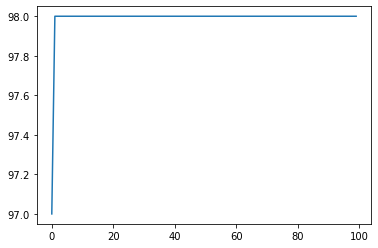

In [56]:
import numpy as np
import matplotlib.pyplot as plt
runtimes=100#number of games
betha=1#learning
N=10 # size of lattice

##### n2 is number of invaders 
n2=1
###### n1 is the number of population
n1=N**2-n2

l=np.ones((N,N)) #the lattice of environment
list_P=[15]
list_o=[0]
for m in list_P:
    for n in list_o:
        n1pop=[]
        l=np.ones((N,N))
        o=np.random.randint(0,N)
        u=np.random.randint(0,N)
        print("u,o",u,o)
        l[o][u]=-1
        s1=m#population
        s2=n#INVADOR
        for w in range(runtimes):
#             print(w)
            n1=main(s1,s2)
            n1pop.append(n1)

n1pop=np.array(n1pop)
time=np.arange(0,len(n1pop))
plt.plot(time,n1pop)
plt.show()

In [59]:
print(S)

[[3.6 3.6 2.  4.  4.  4.  4.  4.  4.  2. ]
 [2.  2.  4.  4.  4.  4.  4.  4.  4.  4. ]
 [4.  4.  4.  4.  4.  4.  4.  4.  4.  4. ]
 [4.  4.  4.  4.  4.  4.  4.  4.  4.  4. ]
 [4.  4.  4.  4.  4.  4.  4.  4.  4.  4. ]
 [4.  4.  4.  4.  4.  4.  4.  4.  4.  4. ]
 [4.  4.  4.  4.  4.  4.  4.  4.  4.  4. ]
 [4.  4.  4.  4.  4.  4.  4.  4.  4.  4. ]
 [4.  4.  4.  4.  4.  4.  4.  4.  4.  4. ]
 [2.  2.  4.  4.  4.  4.  4.  4.  4.  4. ]]


In [92]:
np.arange(0,100)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [ ]:
        count=0 #count full matrix
        stationary_time=0
        for w in range(runtimes):
            if n1==N*N:
                stationary_time=w
                count+=1
                break